In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows', None)  # 设置显示最大
data = pd.read_csv("D:/propycharm2023/mq5/KDATA_type_5.csv")
data = data.drop(['Unnamed: 0', '时间','volume','订单规定价格', '订单ID', 'profit', '类型',
                  'fractals_up_arrow_1D_bin', 'fractals_up_arrow', 'fractals_up_arrow_15M_bin',
          'fractals_up_arrow_30M_bin', 'fractals_up_arrow_1H_bin',
         'fractals_down_arrow_1D_bin', 'fractals_down_arrow', 'fractals_down_arrow_15M_bin',
          'fractals_down_arrow_30M_bin', 'fractals_down_arrow_1H_bin'], axis=1, inplace=False)
data = data.dropna(axis=0)
print(data.shape)
data.describe()

(53174, 6486)


open_price          high           low         close  open_change1  \
count  53174.000000  53174.000000  53174.000000  53174.000000  53174.000000   
mean    1916.322163   1916.865380   1915.773071   1916.323203      0.000059   
std       65.145026     65.166174     65.127573     65.148467      0.045580   
min     1766.270000   1766.790000   1765.850000   1766.280000     -0.889900   
25%     1872.280000   1872.960000   1871.622500   1872.280000     -0.019800   
50%     1925.320000   1925.760000   1924.910000   1925.330000      0.000000   
75%     1961.820000   1962.400000   1961.267500   1961.830000      0.019900   
max     2060.950000   2062.900000   2057.730000   2060.430000      1.377400   

       open_change2  open_change3  open_change4  open_change5  open_change6  \
count  53174.000000  53174.000000  53174.000000  53174.000000  53174.000000   
mean       0.000117      0.000154      0.000141      0.000084      0.000073   
std        0.045262      0.045310      0.044168      0.044337      0.044360   
min       -0.889900     -0.889900     -0.680400     -0.680400     -0.680400   
25%       -0.019700     -0.019700     -0.019700     -0.019700     -0.019700   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.019900      0.019900      0.019900      0.019900      0.019900   
max        1.377400      1.377400      1.377400      1.377400      1.377400   

       open_change7  open_change8  open_change9  open_change10  open_change11  \
count  53174.000000  53174.000000  53174.000000   53174.000000   53174.000000   
mean       0.000057      0.000111      0.000143       0.000107       0.000105   
std        0.044257      0.044366      0.044469       0.044509       0.044662   
min       -0.680400     -0.680400     -0.680400      -0.680400      -0.680400   
25%       -0.019700     -0.019700     -0.019700      -0.019700      -0.019800   
50%        0.000000      0.000000      0.000000       0.000000       0.000000   
75%        0.019900      0.019900      0.020000       0.020000       0.020000   
max        1.377400      1.377400      1.377400       1.377400       1.377400   

       open_change12  open_change13  open_change14  open_change15  \
count   53174.000000   53174.000000    53174.00000   53174.000000   
mean        0.000080       0.000116        0.00010       0.000095   
std         0.044828       0.044903        0.04508       0.045278   
min        -0.680400      -0.680400       -0.68040      -0.680400   
25%        -0.019800      -0.019800       -0.01990      -0.019900   
50%         0.000000       0.000000        0.00000       0.000000   
75%         0.020000       0.020100        0.02010       0.020100   
max         1.377400       1.377400        1.37740       1.377400   

       open_change16  open_change17  open_change18  open_change19  \
count   53174.000000   53174.000000   53174.000000   53174.000000   
mean        0.000108       0.000080       0.000110       0.000115   
std         0.045515       0.045765       0.046637       0.046722   
min        -0.680400      -0.680400      -0.680400      -0.680400   
25%        -0.019900      -0.020000      -0.020000      -0.020000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.020200       0.020200       0.020300       0.020300   
max         1.377400       1.377400       1.377400       1.377400   

       open_change20  open_current_change2  open_current_change3  \
count   53174.000000          53174.000000          53174.000000   
mean        0.000110              0.000176              0.000330   
std         0.046934              0.064068              0.078598   
min        -0.680400             -1.093200             -1.337700   
25%        -0.020100             -0.027900             -0.033900   
50%         0.000000              0.000000              0.000000   
75%         0.020300              0.028200              0.034400   
max         1.377400              1.438800              1.479600   

In [3]:
#注意 需要保持数据类型一致int
col = ['atr_5_10_type', 'macd_type', 'sma_5_10_type', 'ema_5_10_type', 'smma_5_10_type', 'lwma_5_10_type',
       'rsi_5_14_type', 'sar_type', 'adx_type', 'cci_type', 'stoch_type', 'boll_type', 'ac_type', 'ad_type',
       'adxWilder_type',
       'alligator_type', 'ama_type', 'ao_type', 'bearsPower_type', 'bullsPower_type', 'chaikin_type', 'dema_type',
       'deMarker_type', 'envelopes_type', 'force_type', 'fractals_type', 'frAMA_type', 'gator_type',
       'ichimoku_type',
       'bwmfi_type', 'momentum_type', 'mfi_type', 'osMA_type', 'obv_type', 'rvi_type', 'stdDev_type', 'tema_type',
       'triX_type', 'wpr_type', 'vidya_type',
       'ac_color', 'ao_color', 'gator_up_color', 'gator_downs_color', 'bwmfi_color', 
       
        'atr_5_10_type_15M_bin', 'macd_type_15M_bin', 'sma_5_10_type_15M_bin', 'ema_5_10_type_15M_bin', 
       'smma_5_10_type_15M_bin', 'lwma_5_10_type_15M_bin',
       'rsi_5_14_type_15M_bin', 'sar_type_15M_bin', 'adx_type_15M_bin', 'cci_type_15M_bin', 'stoch_type_15M_bin',
       'boll_type_15M_bin', 'ac_type_15M_bin', 'ad_type_15M_bin',
       'adxWilder_type_15M_bin',
       'alligator_type_15M_bin', 'ama_type_15M_bin', 'ao_type_15M_bin', 'bearsPower_type_15M_bin', 'bullsPower_type_15M_bin', 
       'chaikin_type_15M_bin', 'dema_type_15M_bin',
       'deMarker_type_15M_bin', 'envelopes_type_15M_bin', 'force_type_15M_bin', 'fractals_type_15M_bin', 'frAMA_type_15M_bin', 
       'gator_type_15M_bin',
       'ichimoku_type_15M_bin',
       'bwmfi_type_15M_bin', 'momentum_type_15M_bin', 'mfi_type_15M_bin', 'osMA_type_15M_bin', 'obv_type_15M_bin', 
       'rvi_type_15M_bin', 'stdDev_type_15M_bin', 'tema_type_15M_bin',
       'triX_type_15M_bin', 'wpr_type_15M_bin', 'vidya_type_15M_bin',
       'ac_color_15M_bin', 'ao_color_15M_bin', 'gator_up_color_15M_bin', 'gator_downs_color_15M_bin', 'bwmfi_color_15M_bin',
       
      'atr_5_10_type_30M_bin', 'macd_type_30M_bin', 'sma_5_10_type_30M_bin', 'ema_5_10_type_30M_bin', 
       'smma_5_10_type_30M_bin', 'lwma_5_10_type_30M_bin',
       'rsi_5_14_type_30M_bin', 'sar_type_30M_bin', 'adx_type_30M_bin', 'cci_type_30M_bin', 'stoch_type_30M_bin', 
       'boll_type_30M_bin', 'ac_type_30M_bin', 'ad_type_30M_bin',
       'adxWilder_type_30M_bin',
       'alligator_type_30M_bin', 'ama_type_30M_bin', 'ao_type_30M_bin', 'bearsPower_type_30M_bin', 'bullsPower_type_30M_bin', 
       'chaikin_type_30M_bin', 'dema_type_30M_bin',
       'deMarker_type_30M_bin', 'envelopes_type_30M_bin', 'force_type_30M_bin', 'fractals_type_30M_bin', 'frAMA_type_30M_bin', 
       'gator_type_30M_bin',
       'ichimoku_type_30M_bin',
       'bwmfi_type_30M_bin', 'momentum_type_30M_bin', 'mfi_type_30M_bin', 'osMA_type_30M_bin', 'obv_type_30M_bin', 
       'rvi_type_30M_bin', 'stdDev_type_30M_bin', 'tema_type_30M_bin',
       'triX_type_30M_bin', 'wpr_type_30M_bin', 'vidya_type_30M_bin',
       'ac_color_30M_bin', 'ao_color_30M_bin', 'gator_up_color_30M_bin', 'gator_downs_color_30M_bin', 'bwmfi_color_30M_bin',
       
      'atr_5_10_type_1H_bin', 'macd_type_1H_bin', 'sma_5_10_type_1H_bin', 'ema_5_10_type_1H_bin', 
       'smma_5_10_type_1H_bin', 'lwma_5_10_type_1H_bin',
       'rsi_5_14_type_1H_bin', 'sar_type_1H_bin', 'adx_type_1H_bin', 'cci_type_1H_bin', 'stoch_type_1H_bin', 
       'boll_type_1H_bin', 'ac_type_1H_bin', 'ad_type_1H_bin',
       'adxWilder_type_1H_bin',
       'alligator_type_1H_bin', 'ama_type_1H_bin', 'ao_type_1H_bin', 'bearsPower_type_1H_bin', 'bullsPower_type_1H_bin', 
       'chaikin_type_1H_bin', 'dema_type_1H_bin',
       'deMarker_type_1H_bin', 'envelopes_type_1H_bin', 'force_type_1H_bin', 'fractals_type_1H_bin', 'frAMA_type_1H_bin', 
       'gator_type_1H_bin',
       'ichimoku_type_1H_bin',
       'bwmfi_type_1H_bin', 'momentum_type_1H_bin', 'mfi_type_1H_bin', 'osMA_type_1H_bin', 'obv_type_1H_bin', 
       'rvi_type_1H_bin', 'stdDev_type_1H_bin', 'tema_type_1H_bin',
       'triX_type_1H_bin', 'wpr_type_1H_bin', 'vidya_type_1H_bin',
       'ac_color_1H_bin', 'ao_color_1H_bin', 'gator_up_color_1H_bin', 'gator_downs_color_1H_bin', 'bwmfi_color_1H_bin',
      
       'atr_5_10_type_1D_bin', 'macd_type_1D_bin', 'sma_5_10_type_1D_bin', 'ema_5_10_type_1D_bin', 
       'smma_5_10_type_1D_bin', 'lwma_5_10_type_1D_bin',
       'rsi_5_14_type_1D_bin', 'sar_type_1D_bin', 'adx_type_1D_bin', 'cci_type_1D_bin', 'stoch_type_1D_bin', 
       'boll_type_1D_bin', 'ac_type_1D_bin', 'ad_type_1D_bin',
       'adxWilder_type_1D_bin',
       'alligator_type_1D_bin', 'ama_type_1D_bin', 'ao_type_1D_bin', 'bearsPower_type_1D_bin', 'bullsPower_type_1D_bin', 
       'chaikin_type_1D_bin', 'dema_type_1D_bin',
       'deMarker_type_1D_bin', 'envelopes_type_1D_bin', 'force_type_1D_bin', 'fractals_type_1D_bin', 'frAMA_type_1D_bin', 
       'gator_type_1D_bin',
       'ichimoku_type_1D_bin',
       'bwmfi_type_1D_bin', 'momentum_type_1D_bin', 'mfi_type_1D_bin', 'osMA_type_1D_bin', 'obv_type_1D_bin', 
       'rvi_type_1D_bin', 'stdDev_type_1D_bin', 'tema_type_1D_bin',
       'triX_type_1D_bin', 'wpr_type_1D_bin', 'vidya_type_1D_bin',
       'ac_color_1D_bin', 'ao_color_1D_bin', 'gator_up_color_1D_bin', 'gator_downs_color_1D_bin', 'bwmfi_color_1D_bin']

data[col] = (data[col].astype(str))

replace_dict = {'0':'z', '1': 'A', '2': 'B', '3': 'C', '4': 'D', 
                '5': 'E', '6': 'F', '7': 'G', '8': 'H', '9': 'I', 
                '10': 'J', '11':'K', '12':'L', '13':'M', '14':'N'}

data[col] = data[col].replace(replace_dict)



In [4]:
#特征和标签
X = data.iloc[:,:-1]
Y = data.iloc[:, -1]
# #标准化StandardScaler()
scaler = StandardScaler()

# 对指定列进行标准化
X_scaled = scaler.fit_transform((X[X.columns.difference(col)].astype(float)))

# 将标准化后的数据转换为 DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns.difference(col))
# 合并标准化后的数据和其他列
X_merged = pd.concat([X_scaled_df, X[col]], axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(X_merged,Y,test_size=0.2,random_state = 49)

In [5]:
del data  # 删除列表,释放内存
del X_scaled
del X_scaled_df
del X_merged
del X
del Y

In [57]:
Y_train[:-5000].describe()

count    37539.000000
mean         0.465196
std          0.498794
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: type, dtype: float64

# 1

In [8]:
# 
train_pool = Pool(X_train[:-8000],label = Y_train[:-8000],cat_features = col)
eval_pool = Pool(X_train[-8000:],label = Y_train[-8000:],cat_features = col)
test_pool = Pool(X_test,cat_features = col)
# 'one_hot_max_size': 4, # 对唯一值数量<one_hot_max_size的类别型特征使用one-hot编码
# 自定义评估指标函数：AUC
def precision_eval(y_true, y_pred):
    return precision_score(y_true, y_pred)
params = {
    'iterations': 2000,
    'learning_rate': 0.02,
    'depth': 8,
    'early_stopping_rounds': 30,
    'loss_function':"Logloss",
    'od_type':"Iter",
    'class_weights':[1, 1.075],
    'eval_metric':'Accuracy'
    
}
model = CatBoostClassifier(**params)

In [9]:
model.fit(train_pool,eval_set=eval_pool)

0:	learn: 0.6730764	test: 0.6655942	best: 0.6655942 (0)	total: 1.15s	remaining: 38m 10s
1:	learn: 0.7111767	test: 0.6989723	best: 0.6989723 (1)	total: 2.23s	remaining: 37m 13s
2:	learn: 0.7316243	test: 0.7188893	best: 0.7188893 (2)	total: 3.32s	remaining: 36m 49s
3:	learn: 0.7491853	test: 0.7354380	best: 0.7354380 (3)	total: 4.38s	remaining: 36m 25s
4:	learn: 0.7582599	test: 0.7478548	best: 0.7478548 (4)	total: 5.46s	remaining: 36m 20s
5:	learn: 0.7588678	test: 0.7467290	best: 0.7478548 (4)	total: 6.91s	remaining: 38m 14s
6:	learn: 0.7674206	test: 0.7565985	best: 0.7565985 (6)	total: 8.01s	remaining: 38m
7:	learn: 0.7691468	test: 0.7578118	best: 0.7578118 (7)	total: 9.12s	remaining: 37m 51s
8:	learn: 0.7742612	test: 0.7632144	best: 0.7632144 (8)	total: 10.3s	remaining: 37m 52s
9:	learn: 0.7753209	test: 0.7647567	best: 0.7647567 (9)	total: 11.4s	remaining: 37m 44s
10:	learn: 0.7798470	test: 0.7694439	best: 0.7694439 (10)	total: 12.8s	remaining: 38m 39s
11:	learn: 0.7788097	test: 0.76763

92:	learn: 0.8368540	test: 0.8228235	best: 0.8237410 (90)	total: 1m 47s	remaining: 36m 41s
93:	learn: 0.8366211	test: 0.8223587	best: 0.8237410 (90)	total: 1m 48s	remaining: 36m 38s
94:	learn: 0.8369344	test: 0.8230167	best: 0.8237410 (90)	total: 1m 49s	remaining: 36m 35s
95:	learn: 0.8382109	test: 0.8243326	best: 0.8243326 (95)	total: 1m 50s	remaining: 36m 39s
96:	learn: 0.8386914	test: 0.8241032	best: 0.8243326 (95)	total: 1m 51s	remaining: 36m 36s
97:	learn: 0.8398183	test: 0.8256063	best: 0.8256063 (97)	total: 1m 53s	remaining: 36m 33s
98:	learn: 0.8407877	test: 0.8265057	best: 0.8265057 (98)	total: 1m 54s	remaining: 36m 30s
99:	learn: 0.8411164	test: 0.8267743	best: 0.8267743 (99)	total: 1m 55s	remaining: 36m 27s
100:	learn: 0.8420824	test: 0.8282019	best: 0.8282019 (100)	total: 1m 56s	remaining: 36m 31s
101:	learn: 0.8424629	test: 0.8283226	best: 0.8283226 (101)	total: 1m 57s	remaining: 36m 28s
102:	learn: 0.8436918	test: 0.8299736	best: 0.8299736 (102)	total: 1m 58s	remaining: 3

181:	learn: 0.8740499	test: 0.8571312	best: 0.8571584 (179)	total: 3m 27s	remaining: 34m 31s
182:	learn: 0.8743052	test: 0.8567690	best: 0.8571584 (179)	total: 3m 28s	remaining: 34m 29s
183:	learn: 0.8745850	test: 0.8573817	best: 0.8573817 (183)	total: 3m 29s	remaining: 34m 27s
184:	learn: 0.8748487	test: 0.8580669	best: 0.8580669 (184)	total: 3m 30s	remaining: 34m 25s
185:	learn: 0.8752571	test: 0.8591715	best: 0.8591715 (185)	total: 3m 31s	remaining: 34m 26s
186:	learn: 0.8752208	test: 0.8588938	best: 0.8591715 (185)	total: 3m 33s	remaining: 34m 25s
187:	learn: 0.8751368	test: 0.8590236	best: 0.8591715 (185)	total: 3m 34s	remaining: 34m 23s
188:	learn: 0.8754334	test: 0.8590417	best: 0.8591715 (185)	total: 3m 35s	remaining: 34m 20s
189:	learn: 0.8758936	test: 0.8591625	best: 0.8591715 (185)	total: 3m 36s	remaining: 34m 18s
190:	learn: 0.8761790	test: 0.8594311	best: 0.8594311 (190)	total: 3m 37s	remaining: 34m 19s
191:	learn: 0.8766155	test: 0.8603033	best: 0.8603033 (191)	total: 3m 

270:	learn: 0.8946787	test: 0.8755482	best: 0.8755482 (270)	total: 5m 6s	remaining: 32m 37s
271:	learn: 0.8949109	test: 0.8761880	best: 0.8761880 (271)	total: 5m 7s	remaining: 32m 36s
272:	learn: 0.8948871	test: 0.8768279	best: 0.8768279 (272)	total: 5m 9s	remaining: 32m 34s
273:	learn: 0.8952851	test: 0.8769215	best: 0.8769215 (273)	total: 5m 10s	remaining: 32m 33s
274:	learn: 0.8954788	test: 0.8771720	best: 0.8771720 (274)	total: 5m 11s	remaining: 32m 32s
275:	learn: 0.8955348	test: 0.8769033	best: 0.8771720 (274)	total: 5m 12s	remaining: 32m 33s
276:	learn: 0.8956250	test: 0.8769215	best: 0.8771720 (274)	total: 5m 13s	remaining: 32m 32s
277:	learn: 0.8953068	test: 0.8770331	best: 0.8771720 (274)	total: 5m 14s	remaining: 32m 30s
278:	learn: 0.8955005	test: 0.8771539	best: 0.8771720 (274)	total: 5m 15s	remaining: 32m 28s
279:	learn: 0.8955110	test: 0.8771629	best: 0.8771720 (274)	total: 5m 17s	remaining: 32m 27s
280:	learn: 0.8957432	test: 0.8780533	best: 0.8780533 (280)	total: 5m 18s

359:	learn: 0.9067455	test: 0.8870626	best: 0.8870626 (359)	total: 6m 46s	remaining: 30m 50s
360:	learn: 0.9066252	test: 0.8870535	best: 0.8870626 (359)	total: 6m 47s	remaining: 30m 49s
361:	learn: 0.9070253	test: 0.8869328	best: 0.8870626 (359)	total: 6m 48s	remaining: 30m 48s
362:	learn: 0.9072296	test: 0.8870626	best: 0.8870626 (359)	total: 6m 49s	remaining: 30m 47s
363:	learn: 0.9074058	test: 0.8873131	best: 0.8873131 (363)	total: 6m 50s	remaining: 30m 45s
364:	learn: 0.9076681	test: 0.8869147	best: 0.8873131 (363)	total: 6m 51s	remaining: 30m 44s
365:	learn: 0.9076702	test: 0.8871833	best: 0.8873131 (363)	total: 6m 53s	remaining: 30m 44s
366:	learn: 0.9077478	test: 0.8872859	best: 0.8873131 (363)	total: 6m 54s	remaining: 30m 42s
367:	learn: 0.9078961	test: 0.8874066	best: 0.8874066 (367)	total: 6m 55s	remaining: 30m 41s
368:	learn: 0.9081137	test: 0.8875092	best: 0.8875092 (368)	total: 6m 56s	remaining: 30m 39s
369:	learn: 0.9081976	test: 0.8878895	best: 0.8878895 (369)	total: 6m 

448:	learn: 0.9153152	test: 0.8959179	best: 0.8959179 (448)	total: 8m 25s	remaining: 29m 4s
449:	learn: 0.9153194	test: 0.8961684	best: 0.8961684 (449)	total: 8m 26s	remaining: 29m 3s
450:	learn: 0.9155215	test: 0.8961775	best: 0.8961775 (450)	total: 8m 27s	remaining: 29m 3s
451:	learn: 0.9155879	test: 0.8961865	best: 0.8961865 (451)	total: 8m 28s	remaining: 29m 1s
452:	learn: 0.9158139	test: 0.8960567	best: 0.8961865 (451)	total: 8m 29s	remaining: 29m
453:	learn: 0.9159859	test: 0.8958062	best: 0.8961865 (451)	total: 8m 30s	remaining: 28m 59s
454:	learn: 0.9160720	test: 0.8961684	best: 0.8961865 (451)	total: 8m 31s	remaining: 28m 57s
455:	learn: 0.9162419	test: 0.8962982	best: 0.8962982 (455)	total: 8m 33s	remaining: 28m 57s
456:	learn: 0.9163818	test: 0.8966694	best: 0.8966694 (456)	total: 8m 34s	remaining: 28m 56s
457:	learn: 0.9163259	test: 0.8965397	best: 0.8966694 (456)	total: 8m 35s	remaining: 28m 54s
458:	learn: 0.9162937	test: 0.8966604	best: 0.8966694 (456)	total: 8m 36s	rema

537:	learn: 0.9224264	test: 0.9011907	best: 0.9011907 (537)	total: 10m 4s	remaining: 27m 22s
538:	learn: 0.9224565	test: 0.9011907	best: 0.9011907 (537)	total: 10m 5s	remaining: 27m 21s
539:	learn: 0.9225104	test: 0.9011907	best: 0.9011907 (537)	total: 10m 6s	remaining: 27m 19s
540:	learn: 0.9226202	test: 0.9015619	best: 0.9015619 (540)	total: 10m 7s	remaining: 27m 19s
541:	learn: 0.9227146	test: 0.9016736	best: 0.9016736 (541)	total: 10m 8s	remaining: 27m 18s
542:	learn: 0.9226545	test: 0.9015529	best: 0.9016736 (541)	total: 10m 9s	remaining: 27m 16s
543:	learn: 0.9227125	test: 0.9020358	best: 0.9020358 (543)	total: 10m 11s	remaining: 27m 15s
544:	learn: 0.9228349	test: 0.9020448	best: 0.9020448 (544)	total: 10m 12s	remaining: 27m 14s
545:	learn: 0.9229811	test: 0.9018034	best: 0.9020448 (544)	total: 10m 13s	remaining: 27m 13s
546:	learn: 0.9230930	test: 0.9019241	best: 0.9020448 (544)	total: 10m 14s	remaining: 27m 12s
547:	learn: 0.9230308	test: 0.9020448	best: 0.9020448 (544)	total:

625:	learn: 0.9296937	test: 0.9084283	best: 0.9084373 (622)	total: 11m 42s	remaining: 25m 41s
626:	learn: 0.9298077	test: 0.9083076	best: 0.9084373 (622)	total: 11m 43s	remaining: 25m 40s
627:	learn: 0.9297217	test: 0.9083076	best: 0.9084373 (622)	total: 11m 44s	remaining: 25m 39s
628:	learn: 0.9299217	test: 0.9081868	best: 0.9084373 (622)	total: 11m 45s	remaining: 25m 38s
629:	learn: 0.9300812	test: 0.9083076	best: 0.9084373 (622)	total: 11m 46s	remaining: 25m 36s
630:	learn: 0.9299714	test: 0.9081959	best: 0.9084373 (622)	total: 11m 48s	remaining: 25m 36s
631:	learn: 0.9300917	test: 0.9080752	best: 0.9084373 (622)	total: 11m 49s	remaining: 25m 35s
632:	learn: 0.9301581	test: 0.9078156	best: 0.9084373 (622)	total: 11m 50s	remaining: 25m 33s
633:	learn: 0.9302204	test: 0.9084373	best: 0.9084373 (622)	total: 11m 51s	remaining: 25m 32s
634:	learn: 0.9303903	test: 0.9085581	best: 0.9085581 (634)	total: 11m 52s	remaining: 25m 31s
635:	learn: 0.9304442	test: 0.9084283	best: 0.9085581 (634)	

713:	learn: 0.9355110	test: 0.9131155	best: 0.9131155 (713)	total: 13m 20s	remaining: 24m 1s
714:	learn: 0.9352767	test: 0.9129857	best: 0.9131155 (713)	total: 13m 21s	remaining: 24m
715:	learn: 0.9353347	test: 0.9132272	best: 0.9132272 (715)	total: 13m 22s	remaining: 23m 59s
716:	learn: 0.9354788	test: 0.9131155	best: 0.9132272 (715)	total: 13m 23s	remaining: 23m 58s
717:	learn: 0.9356852	test: 0.9129857	best: 0.9132272 (715)	total: 13m 24s	remaining: 23m 56s
718:	learn: 0.9359537	test: 0.9128560	best: 0.9132272 (715)	total: 13m 25s	remaining: 23m 55s
719:	learn: 0.9359537	test: 0.9132272	best: 0.9132272 (715)	total: 13m 26s	remaining: 23m 54s
720:	learn: 0.9361559	test: 0.9133570	best: 0.9133570 (720)	total: 13m 28s	remaining: 23m 53s
721:	learn: 0.9361860	test: 0.9136075	best: 0.9136075 (721)	total: 13m 29s	remaining: 23m 52s
722:	learn: 0.9364420	test: 0.9136075	best: 0.9136075 (721)	total: 13m 30s	remaining: 23m 51s
723:	learn: 0.9364182	test: 0.9137373	best: 0.9137373 (723)	total

801:	learn: 0.9418221	test: 0.9164567	best: 0.9165864 (790)	total: 14m 58s	remaining: 22m 21s
802:	learn: 0.9419102	test: 0.9161971	best: 0.9165864 (790)	total: 14m 59s	remaining: 22m 20s
803:	learn: 0.9418263	test: 0.9161971	best: 0.9165864 (790)	total: 15m	remaining: 22m 19s
804:	learn: 0.9419060	test: 0.9161971	best: 0.9165864 (790)	total: 15m 1s	remaining: 22m 17s
805:	learn: 0.9420305	test: 0.9164476	best: 0.9165864 (790)	total: 15m 2s	remaining: 22m 17s
806:	learn: 0.9420606	test: 0.9163178	best: 0.9165864 (790)	total: 15m 3s	remaining: 22m 15s
807:	learn: 0.9420305	test: 0.9165683	best: 0.9165864 (790)	total: 15m 4s	remaining: 22m 14s
808:	learn: 0.9421166	test: 0.9164385	best: 0.9165864 (790)	total: 15m 5s	remaining: 22m 13s
809:	learn: 0.9420844	test: 0.9163178	best: 0.9165864 (790)	total: 15m 6s	remaining: 22m 12s
810:	learn: 0.9422348	test: 0.9164567	best: 0.9165864 (790)	total: 15m 8s	remaining: 22m 11s
811:	learn: 0.9422928	test: 0.9163269	best: 0.9165864 (790)	total: 15m 

889:	learn: 0.9464853	test: 0.9192213	best: 0.9193601 (885)	total: 16m 35s	remaining: 20m 41s
890:	learn: 0.9465175	test: 0.9193511	best: 0.9193601 (885)	total: 16m 37s	remaining: 20m 41s
891:	learn: 0.9466658	test: 0.9193511	best: 0.9193601 (885)	total: 16m 38s	remaining: 20m 39s
892:	learn: 0.9468141	test: 0.9192304	best: 0.9193601 (885)	total: 16m 39s	remaining: 20m 38s
893:	learn: 0.9468700	test: 0.9192304	best: 0.9193601 (885)	total: 16m 40s	remaining: 20m 37s
894:	learn: 0.9469840	test: 0.9193511	best: 0.9193601 (885)	total: 16m 41s	remaining: 20m 36s
895:	learn: 0.9469819	test: 0.9193511	best: 0.9193601 (885)	total: 16m 42s	remaining: 20m 35s
896:	learn: 0.9470701	test: 0.9191006	best: 0.9193601 (885)	total: 16m 43s	remaining: 20m 34s
897:	learn: 0.9471582	test: 0.9191006	best: 0.9193601 (885)	total: 16m 44s	remaining: 20m 33s
898:	learn: 0.9471043	test: 0.9191006	best: 0.9193601 (885)	total: 16m 45s	remaining: 20m 31s
899:	learn: 0.9470721	test: 0.9192304	best: 0.9193601 (885)	

977:	learn: 0.9510282	test: 0.9211409	best: 0.9213914 (971)	total: 18m 13s	remaining: 19m 2s
978:	learn: 0.9510282	test: 0.9213823	best: 0.9213914 (971)	total: 18m 14s	remaining: 19m 1s
979:	learn: 0.9512283	test: 0.9212616	best: 0.9213914 (971)	total: 18m 15s	remaining: 19m
980:	learn: 0.9511982	test: 0.9212616	best: 0.9213914 (971)	total: 18m 17s	remaining: 18m 59s
981:	learn: 0.9514024	test: 0.9210020	best: 0.9213914 (971)	total: 18m 18s	remaining: 18m 58s
982:	learn: 0.9513723	test: 0.9211318	best: 0.9213914 (971)	total: 18m 19s	remaining: 18m 57s
983:	learn: 0.9513703	test: 0.9213823	best: 0.9213914 (971)	total: 18m 20s	remaining: 18m 56s
984:	learn: 0.9514864	test: 0.9213823	best: 0.9213914 (971)	total: 18m 21s	remaining: 18m 54s
985:	learn: 0.9514885	test: 0.9213823	best: 0.9213914 (971)	total: 18m 22s	remaining: 18m 53s
986:	learn: 0.9515185	test: 0.9212525	best: 0.9213914 (971)	total: 18m 23s	remaining: 18m 52s
987:	learn: 0.9515465	test: 0.9213823	best: 0.9213914 (971)	total:

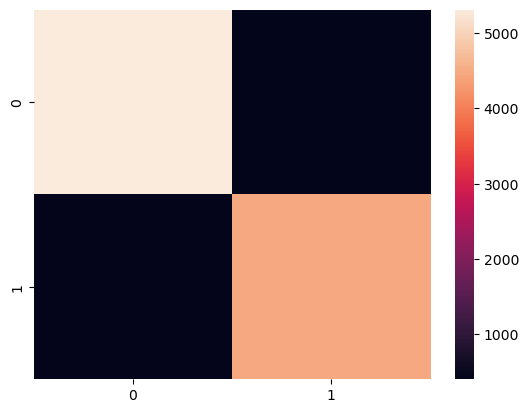

[[5312  404]
 [ 437 4482]]
roc_auc: 0.9202410043402919 Accuracy: 0.9209214856605548 f1: 0.9142274349821521 recall: 0.9111608050416752 precision: 0.9173147769136308


In [10]:
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

In [11]:
feature_importance = model.get_feature_importance()
feature_dic ={}
for feature, importance in zip(X_train.columns, feature_importance):
    feature_dic[feature] = importance
sorted_feature_dic = dict(sorted(feature_dic.items(), key=lambda x: x[1],reverse=True))
for key,value in sorted_feature_dic.items():
    print(key,value)

bulls_changeValue9_1D_bin 1.4040928272307793
rvi_change9_1D_bin 1.3002872772478904
force_changeValue9_1D_bin 0.8824237515122618
ac_change3_1D_bin 0.8691923783353993
gator_ups_1D_bin 0.8220732509172792
gator_downs_1D_bin 0.766119184739953
bwmfi_current_change2_1D_bin 0.609320356064165
ac_change4_1D_bin 0.6058585524773444
obv 0.566095905485606
mfi_change4_1D_bin 0.468429268461984
atr10_current_change6_1H_bin 0.4611475182062478
ao_changeValue10_1H_bin 0.4562483651026462
obv_current_change9_30M_bin 0.4478807508756159
wpr_changeValue10_1D_bin 0.4141629100176365
cci_change10_1D_bin 0.3930860773706151
stdDev_1H_bin 0.38815190600859295
atr10_current_change5_1H_bin 0.3863600757696706
bwmfi_change9_1D_bin 0.3821040545011369
bulls_change5_1D_bin 0.38112363381605774
ac_changeValue4_1D_bin 0.3680082868658875
atr10_current_change3_1H_bin 0.3517556551209092
atr10_change10_1H_bin 0.34496338041470215
atr10_changeValue10_1H_bin 0.33837670079170334
sar_current_change7_1H_bin 0.32856101544117705
macd_curr

In [28]:
df = pd.DataFrame(list(sorted_feature_dic.items()), columns=["name", "weight"])

top = 20
df_name = df['name'].apply(lambda x: x)
# print(df_name)
df_name = df_name.apply(lambda x: x.split('_')[0])

print('\n统计TOP:\n',df_name[:top].value_counts())

name_top = df_name[:top].drop_duplicates()
print('\n排名（去重）:\n', name_top,'\n 数量：',len(name_top))

df_weight = df['weight'].apply(lambda x: float(x))
num = len(df_weight[df_weight[:] > 0])
print('\n大于1：   ', len(df_weight[df_weight[:] >= 1]), '    ', round(len(df_weight[df_weight[:] >= 1])*100/num, 2), '(%)',
    '\n大于0.5： ', len(df_weight[df_weight[:] >= 0.5]), '    ', round(len(df_weight[df_weight[:] >= 0.5])*100/num, 2), '(%)',
    '\n大于0.4： ', len(df_weight[df_weight[:] >= 0.4]), '   ', round(len(df_weight[df_weight[:] >= 0.4])*100/num, 2), '(%)',
    '\n大于0.3： ', len(df_weight[df_weight[:] >= 0.3]), '   ', round(len(df_weight[df_weight[:] >= 0.3])*100/num, 2), '(%)',
    '\n大于0.2： ', len(df_weight[df_weight[:] >= 0.2]), '   ', round(len(df_weight[df_weight[:] >= 0.2])*100/num, 2), '(%)',
    '\n大于0.1： ', len(df_weight[df_weight[:] >= 0.1]), '  ', round(len(df_weight[df_weight[:] >= 0.1])*100/num, 2), '(%)',
    '\n大于0.01：', len(df_weight[df_weight[:] >= 0.01]), ' ', round(len(df_weight[df_weight[:] >= 0.01])*100/num, 2), '(%)',
    '\n大于0：   ', num, ' ', round(num*100/num, 2), '(%)',
    '\n等于0：   ', len(df_weight[df_weight[:] == 0]),
    '\n总计0：   ', len(df_weight[df_weight[:] >= 0])
      )



统计TOP:
 ac        3
bulls     2
gator     2
bwmfi     2
obv       2
atr10     2
rvi       1
force     1
mfi       1
ao        1
wpr       1
cci       1
stdDev    1
Name: name, dtype: int64

排名（去重）:
 0      bulls
1        rvi
2      force
3         ac
4      gator
6      bwmfi
8        obv
9        mfi
10     atr10
11        ao
13       wpr
14       cci
15    stdDev
Name: name, dtype: object 
 数量： 13

大于1：    2      0.07 (%) 
大于0.5：  9      0.3 (%) 
大于0.4：  14     0.47 (%) 
大于0.3：  24     0.8 (%) 
大于0.2：  39     1.3 (%) 
大于0.1：  188    6.29 (%) 
大于0.01： 1923   64.31 (%) 
大于0：    2990   100.0 (%) 
等于0：    3495 
总计0：    6485


# 2

In [16]:
params = {
    'iterations': 2000,
    'learning_rate': 0.01,
    'depth': 8,
    'early_stopping_rounds': 20,
    'loss_function':"Logloss",
    'od_type':"Iter",
    'class_weights':[1, 1.075],
    'eval_metric':'Accuracy'
    
}
model = CatBoostClassifier(**params)

model.fit(train_pool,eval_set=eval_pool)

0:	learn: 0.6661235	test: 0.6548192	best: 0.6548192 (0)	total: 1.22s	remaining: 40m 38s
1:	learn: 0.6944050	test: 0.6882512	best: 0.6882512 (1)	total: 2.34s	remaining: 39m 1s
2:	learn: 0.7168078	test: 0.7141450	best: 0.7141450 (2)	total: 3.46s	remaining: 38m 21s
3:	learn: 0.7228839	test: 0.7251167	best: 0.7251167 (3)	total: 4.59s	remaining: 38m 11s
4:	learn: 0.7341549	test: 0.7344852	best: 0.7344852 (4)	total: 5.73s	remaining: 38m 7s
5:	learn: 0.7506621	test: 0.7503103	best: 0.7503103 (5)	total: 7.26s	remaining: 40m 12s
6:	learn: 0.7562528	test: 0.7568730	best: 0.7568730 (6)	total: 8.34s	remaining: 39m 34s
7:	learn: 0.7631332	test: 0.7606156	best: 0.7606156 (7)	total: 9.47s	remaining: 39m 18s
8:	learn: 0.7655103	test: 0.7607943	best: 0.7607943 (8)	total: 10.6s	remaining: 39m 6s
9:	learn: 0.7682008	test: 0.7651164	best: 0.7651164 (9)	total: 11.7s	remaining: 38m 54s
10:	learn: 0.7671021	test: 0.7640346	best: 0.7651164 (9)	total: 13.3s	remaining: 40m 7s
11:	learn: 0.7668090	test: 0.762117

92:	learn: 0.8080104	test: 0.8019674	best: 0.8019674 (92)	total: 1m 51s	remaining: 38m 1s
93:	learn: 0.8090115	test: 0.8022185	best: 0.8022185 (93)	total: 1m 52s	remaining: 37m 59s
94:	learn: 0.8090865	test: 0.8031988	best: 0.8031988 (94)	total: 1m 53s	remaining: 37m 56s
95:	learn: 0.8098373	test: 0.8050097	best: 0.8050097 (95)	total: 1m 55s	remaining: 38m 2s
96:	learn: 0.8113413	test: 0.8064053	best: 0.8064053 (96)	total: 1m 56s	remaining: 37m 58s
97:	learn: 0.8117674	test: 0.8071925	best: 0.8071925 (97)	total: 1m 57s	remaining: 37m 55s
98:	learn: 0.8120121	test: 0.8073857	best: 0.8073857 (98)	total: 1m 58s	remaining: 37m 51s
99:	learn: 0.8127922	test: 0.8083805	best: 0.8083805 (99)	total: 1m 59s	remaining: 37m 48s
100:	learn: 0.8132037	test: 0.8084239	best: 0.8084239 (100)	total: 2m	remaining: 37m 53s
101:	learn: 0.8135887	test: 0.8084819	best: 0.8084819 (101)	total: 2m 2s	remaining: 37m 50s
102:	learn: 0.8143424	test: 0.8084819	best: 0.8084819 (101)	total: 2m 3s	remaining: 37m 47s
1

181:	learn: 0.8391042	test: 0.8298797	best: 0.8306813 (176)	total: 3m 37s	remaining: 36m 15s
182:	learn: 0.8392846	test: 0.8302805	best: 0.8306813 (176)	total: 3m 38s	remaining: 36m 13s
183:	learn: 0.8391161	test: 0.8298942	best: 0.8306813 (176)	total: 3m 39s	remaining: 36m 11s
184:	learn: 0.8397226	test: 0.8304737	best: 0.8306813 (176)	total: 3m 41s	remaining: 36m 9s
185:	learn: 0.8404030	test: 0.8309035	best: 0.8309035 (185)	total: 3m 42s	remaining: 36m 11s
186:	learn: 0.8402034	test: 0.8307248	best: 0.8309035 (185)	total: 3m 43s	remaining: 36m 9s
187:	learn: 0.8409475	test: 0.8313188	best: 0.8313188 (187)	total: 3m 44s	remaining: 36m 7s
188:	learn: 0.8414723	test: 0.8307103	best: 0.8313188 (187)	total: 3m 45s	remaining: 36m 5s
189:	learn: 0.8416662	test: 0.8309035	best: 0.8313188 (187)	total: 3m 47s	remaining: 36m 3s
190:	learn: 0.8416420	test: 0.8304882	best: 0.8313188 (187)	total: 3m 48s	remaining: 36m 5s
191:	learn: 0.8416572	test: 0.8319417	best: 0.8319417 (191)	total: 3m 49s	re

270:	learn: 0.8582326	test: 0.8463905	best: 0.8463905 (270)	total: 5m 23s	remaining: 34m 24s
271:	learn: 0.8582100	test: 0.8461973	best: 0.8463905 (270)	total: 5m 24s	remaining: 34m 22s
272:	learn: 0.8583904	test: 0.8465836	best: 0.8465836 (272)	total: 5m 25s	remaining: 34m 20s
273:	learn: 0.8584197	test: 0.8463905	best: 0.8465836 (272)	total: 5m 26s	remaining: 34m 19s
274:	learn: 0.8580764	test: 0.8457675	best: 0.8465836 (272)	total: 5m 28s	remaining: 34m 17s
275:	learn: 0.8581773	test: 0.8457820	best: 0.8465836 (272)	total: 5m 29s	remaining: 34m 18s
276:	learn: 0.8581232	test: 0.8459897	best: 0.8465836 (272)	total: 5m 30s	remaining: 34m 16s
277:	learn: 0.8581925	test: 0.8459897	best: 0.8465836 (272)	total: 5m 31s	remaining: 34m 14s
278:	learn: 0.8582585	test: 0.8461973	best: 0.8465836 (272)	total: 5m 32s	remaining: 34m 12s
279:	learn: 0.8586001	test: 0.8465836	best: 0.8465836 (272)	total: 5m 33s	remaining: 34m 11s
280:	learn: 0.8583921	test: 0.8463905	best: 0.8465836 (272)	total: 5m 

359:	learn: 0.8734167	test: 0.8592166	best: 0.8596319 (358)	total: 7m 8s	remaining: 32m 30s
360:	learn: 0.8735413	test: 0.8590235	best: 0.8596319 (358)	total: 7m 9s	remaining: 32m 30s
361:	learn: 0.8735204	test: 0.8602259	best: 0.8602259 (361)	total: 7m 10s	remaining: 32m 28s
362:	learn: 0.8738790	test: 0.8608489	best: 0.8608489 (362)	total: 7m 11s	remaining: 32m 27s
363:	learn: 0.8742273	test: 0.8612497	best: 0.8612497 (363)	total: 7m 12s	remaining: 32m 25s
364:	learn: 0.8742673	test: 0.8610420	best: 0.8612497 (363)	total: 7m 13s	remaining: 32m 23s
365:	learn: 0.8744928	test: 0.8610275	best: 0.8612497 (363)	total: 7m 15s	remaining: 32m 24s
366:	learn: 0.8746315	test: 0.8610131	best: 0.8612497 (363)	total: 7m 16s	remaining: 32m 22s
367:	learn: 0.8749105	test: 0.8616215	best: 0.8616215 (367)	total: 7m 17s	remaining: 32m 21s
368:	learn: 0.8749697	test: 0.8618147	best: 0.8618147 (368)	total: 7m 18s	remaining: 32m 19s
369:	learn: 0.8749178	test: 0.8622010	best: 0.8622010 (369)	total: 7m 19

448:	learn: 0.8836088	test: 0.8721635	best: 0.8721635 (445)	total: 8m 52s	remaining: 30m 41s
449:	learn: 0.8836731	test: 0.8725643	best: 0.8725643 (449)	total: 8m 54s	remaining: 30m 39s
450:	learn: 0.8836263	test: 0.8723711	best: 0.8725643 (449)	total: 8m 55s	remaining: 30m 39s
451:	learn: 0.8837199	test: 0.8723711	best: 0.8725643 (449)	total: 8m 56s	remaining: 30m 38s
452:	learn: 0.8838202	test: 0.8723711	best: 0.8725643 (449)	total: 8m 57s	remaining: 30m 36s
453:	learn: 0.8838118	test: 0.8721635	best: 0.8725643 (449)	total: 8m 58s	remaining: 30m 35s
454:	learn: 0.8840474	test: 0.8721635	best: 0.8725643 (449)	total: 9m	remaining: 30m 33s
455:	learn: 0.8842019	test: 0.8727285	best: 0.8727285 (455)	total: 9m 1s	remaining: 30m 33s
456:	learn: 0.8843354	test: 0.8727285	best: 0.8727285 (455)	total: 9m 2s	remaining: 30m 32s
457:	learn: 0.8843907	test: 0.8731583	best: 0.8731583 (457)	total: 9m 3s	remaining: 30m 30s
458:	learn: 0.8844792	test: 0.8731583	best: 0.8731583 (457)	total: 9m 4s	rema

537:	learn: 0.8932858	test: 0.8831063	best: 0.8831063 (537)	total: 10m 38s	remaining: 28m 55s
538:	learn: 0.8932147	test: 0.8827200	best: 0.8831063 (537)	total: 10m 39s	remaining: 28m 53s
539:	learn: 0.8931679	test: 0.8827200	best: 0.8831063 (537)	total: 10m 40s	remaining: 28m 52s
540:	learn: 0.8931662	test: 0.8829276	best: 0.8831063 (537)	total: 10m 42s	remaining: 28m 51s
541:	learn: 0.8934644	test: 0.8837003	best: 0.8837003 (541)	total: 10m 43s	remaining: 28m 50s
542:	learn: 0.8934678	test: 0.8837003	best: 0.8837003 (541)	total: 10m 44s	remaining: 28m 49s
543:	learn: 0.8937677	test: 0.8837003	best: 0.8837003 (541)	total: 10m 45s	remaining: 28m 47s
544:	learn: 0.8937762	test: 0.8833139	best: 0.8837003 (541)	total: 10m 46s	remaining: 28m 46s
545:	learn: 0.8939892	test: 0.8835071	best: 0.8837003 (541)	total: 10m 48s	remaining: 28m 46s
546:	learn: 0.8941471	test: 0.8841011	best: 0.8841011 (546)	total: 10m 49s	remaining: 28m 44s
547:	learn: 0.8942198	test: 0.8841011	best: 0.8841011 (546)	

625:	learn: 0.9000100	test: 0.8906059	best: 0.8914510 (615)	total: 12m 22s	remaining: 27m 9s
626:	learn: 0.8999926	test: 0.8910502	best: 0.8914510 (615)	total: 12m 23s	remaining: 27m 8s
627:	learn: 0.9000134	test: 0.8914510	best: 0.8914510 (615)	total: 12m 24s	remaining: 27m 6s
628:	learn: 0.9002874	test: 0.8916442	best: 0.8916442 (628)	total: 12m 25s	remaining: 27m 5s
629:	learn: 0.9003950	test: 0.8920305	best: 0.8920305 (629)	total: 12m 26s	remaining: 27m 4s
630:	learn: 0.9003674	test: 0.8920305	best: 0.8920305 (629)	total: 12m 28s	remaining: 27m 3s
631:	learn: 0.9005286	test: 0.8920305	best: 0.8920305 (629)	total: 12m 29s	remaining: 27m 2s
632:	learn: 0.9004542	test: 0.8922237	best: 0.8922237 (632)	total: 12m 30s	remaining: 27m 1s
633:	learn: 0.9005252	test: 0.8922092	best: 0.8922237 (632)	total: 12m 31s	remaining: 26m 59s
634:	learn: 0.9005027	test: 0.8928176	best: 0.8928176 (634)	total: 12m 32s	remaining: 26m 58s
635:	learn: 0.9007124	test: 0.8930398	best: 0.8930398 (635)	total: 1

713:	learn: 0.9049423	test: 0.8967968	best: 0.8972121 (712)	total: 14m 5s	remaining: 25m 23s
714:	learn: 0.9050134	test: 0.8967968	best: 0.8972121 (712)	total: 14m 7s	remaining: 25m 22s
715:	learn: 0.9049908	test: 0.8967968	best: 0.8972121 (712)	total: 14m 8s	remaining: 25m 21s
716:	learn: 0.9050878	test: 0.8972121	best: 0.8972121 (712)	total: 14m 9s	remaining: 25m 20s
717:	learn: 0.9050618	test: 0.8972121	best: 0.8972121 (712)	total: 14m 10s	remaining: 25m 19s
718:	learn: 0.9050117	test: 0.8972121	best: 0.8972121 (712)	total: 14m 11s	remaining: 25m 17s
719:	learn: 0.9051729	test: 0.8972121	best: 0.8972121 (712)	total: 14m 13s	remaining: 25m 16s
720:	learn: 0.9053583	test: 0.8974198	best: 0.8974198 (720)	total: 14m 14s	remaining: 25m 15s
721:	learn: 0.9053967	test: 0.8976130	best: 0.8976130 (721)	total: 14m 15s	remaining: 25m 14s
722:	learn: 0.9055387	test: 0.8978206	best: 0.8978206 (722)	total: 14m 16s	remaining: 25m 13s
723:	learn: 0.9053257	test: 0.8976130	best: 0.8978206 (722)	tota

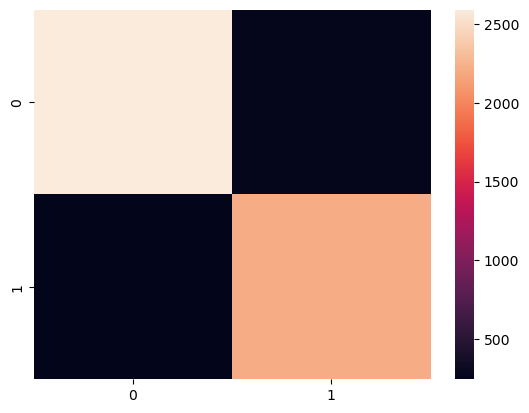

[[2592  270]
 [ 245 2211]]
roc_auc: 0.9029523385163788 Accuracy: 0.9031590823617901 f1: 0.8956856390520559 recall: 0.9002442996742671 precision: 0.8911729141475212


In [17]:
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

# 3

In [18]:
params = {
    'iterations': 2000,
    'learning_rate': 0.02,
    'depth': 6,
    'early_stopping_rounds': 30,
    'loss_function':"Logloss",
    'od_type':"Iter",
    'class_weights':[1, 1.075],
    'eval_metric':'Accuracy'
    
}
model = CatBoostClassifier(**params)

model.fit(train_pool,eval_set=eval_pool)

0:	learn: 0.6456282	test: 0.6454894	best: 0.6454894 (0)	total: 485ms	remaining: 16m 9s
1:	learn: 0.6628862	test: 0.6701662	best: 0.6701662 (1)	total: 911ms	remaining: 15m 9s
2:	learn: 0.6814666	test: 0.6793125	best: 0.6793125 (2)	total: 1.34s	remaining: 14m 53s
3:	learn: 0.6895218	test: 0.6809931	best: 0.6809931 (3)	total: 1.78s	remaining: 14m 49s
4:	learn: 0.6928120	test: 0.6901732	best: 0.6901732 (4)	total: 2.2s	remaining: 14m 39s
5:	learn: 0.6972263	test: 0.7022026	best: 0.7022026 (5)	total: 2.62s	remaining: 14m 31s
6:	learn: 0.6942934	test: 0.6929451	best: 0.7022026 (5)	total: 3.05s	remaining: 14m 29s
7:	learn: 0.7014010	test: 0.7009373	best: 0.7022026 (5)	total: 3.62s	remaining: 15m 1s
8:	learn: 0.7032291	test: 0.7014396	best: 0.7022026 (5)	total: 4.03s	remaining: 14m 52s
9:	learn: 0.7037555	test: 0.7029849	best: 0.7029849 (9)	total: 4.44s	remaining: 14m 44s
10:	learn: 0.7121540	test: 0.7101513	best: 0.7101513 (10)	total: 4.85s	remaining: 14m 36s
11:	learn: 0.7122769	test: 0.71094

92:	learn: 0.7770733	test: 0.7723794	best: 0.7734611 (86)	total: 41s	remaining: 13m 59s
93:	learn: 0.7778647	test: 0.7732100	best: 0.7734611 (86)	total: 41.4s	remaining: 13m 58s
94:	learn: 0.7797508	test: 0.7761171	best: 0.7761171 (94)	total: 41.8s	remaining: 13m 57s
95:	learn: 0.7815529	test: 0.7764889	best: 0.7764889 (95)	total: 42.2s	remaining: 13m 56s
96:	learn: 0.7827852	test: 0.7779570	best: 0.7779570 (96)	total: 42.6s	remaining: 13m 55s
97:	learn: 0.7835084	test: 0.7769477	best: 0.7779570 (96)	total: 43s	remaining: 13m 55s
98:	learn: 0.7838449	test: 0.7761026	best: 0.7779570 (96)	total: 43.6s	remaining: 13m 57s
99:	learn: 0.7848111	test: 0.7773340	best: 0.7779570 (96)	total: 44s	remaining: 13m 56s
100:	learn: 0.7847536	test: 0.7769332	best: 0.7779570 (96)	total: 44.4s	remaining: 13m 55s
101:	learn: 0.7857434	test: 0.7783143	best: 0.7783143 (101)	total: 44.9s	remaining: 13m 54s
102:	learn: 0.7854441	test: 0.7785220	best: 0.7785220 (102)	total: 45.3s	remaining: 13m 53s
103:	learn:

182:	learn: 0.8180351	test: 0.8120023	best: 0.8120023 (182)	total: 1m 20s	remaining: 13m 23s
183:	learn: 0.8194128	test: 0.8142430	best: 0.8142430 (183)	total: 1m 21s	remaining: 13m 22s
184:	learn: 0.8195481	test: 0.8132337	best: 0.8142430 (183)	total: 1m 21s	remaining: 13m 22s
185:	learn: 0.8197172	test: 0.8128619	best: 0.8142430 (183)	total: 1m 22s	remaining: 13m 21s
186:	learn: 0.8200413	test: 0.8126542	best: 0.8142430 (183)	total: 1m 22s	remaining: 13m 20s
187:	learn: 0.8201800	test: 0.8130550	best: 0.8142430 (183)	total: 1m 23s	remaining: 13m 20s
188:	learn: 0.8203293	test: 0.8133834	best: 0.8142430 (183)	total: 1m 23s	remaining: 13m 19s
189:	learn: 0.8211123	test: 0.8129826	best: 0.8142430 (183)	total: 1m 23s	remaining: 13m 20s
190:	learn: 0.8218941	test: 0.8144217	best: 0.8144217 (190)	total: 1m 24s	remaining: 13m 19s
191:	learn: 0.8221044	test: 0.8154165	best: 0.8154165 (191)	total: 1m 24s	remaining: 13m 19s
192:	learn: 0.8225599	test: 0.8154020	best: 0.8154165 (191)	total: 1m 

271:	learn: 0.8407079	test: 0.8311208	best: 0.8313574 (268)	total: 2m	remaining: 12m 43s
272:	learn: 0.8409819	test: 0.8313140	best: 0.8313574 (268)	total: 2m	remaining: 12m 43s
273:	learn: 0.8407688	test: 0.8309421	best: 0.8313574 (268)	total: 2m 1s	remaining: 12m 43s
274:	learn: 0.8408449	test: 0.8307489	best: 0.8313574 (268)	total: 2m 1s	remaining: 12m 43s
275:	learn: 0.8410304	test: 0.8313574	best: 0.8313574 (268)	total: 2m 2s	remaining: 12m 42s
276:	learn: 0.8409977	test: 0.8307489	best: 0.8313574 (268)	total: 2m 2s	remaining: 12m 41s
277:	learn: 0.8408883	test: 0.8307200	best: 0.8313574 (268)	total: 2m 2s	remaining: 12m 41s
278:	learn: 0.8409684	test: 0.8313140	best: 0.8313574 (268)	total: 2m 3s	remaining: 12m 40s
279:	learn: 0.8410879	test: 0.8311208	best: 0.8313574 (268)	total: 2m 3s	remaining: 12m 40s
280:	learn: 0.8410929	test: 0.8307345	best: 0.8313574 (268)	total: 2m 4s	remaining: 12m 40s
281:	learn: 0.8415033	test: 0.8319659	best: 0.8319659 (281)	total: 2m 4s	remaining: 12

360:	learn: 0.8573966	test: 0.8464388	best: 0.8464388 (360)	total: 2m 39s	remaining: 12m 5s
361:	learn: 0.8575871	test: 0.8464388	best: 0.8464388 (360)	total: 2m 40s	remaining: 12m 4s
362:	learn: 0.8578938	test: 0.8464388	best: 0.8464388 (360)	total: 2m 40s	remaining: 12m 4s
363:	learn: 0.8579857	test: 0.8460235	best: 0.8464388 (360)	total: 2m 40s	remaining: 12m 3s
364:	learn: 0.8581593	test: 0.8454005	best: 0.8464388 (360)	total: 2m 41s	remaining: 12m 3s
365:	learn: 0.8581784	test: 0.8456082	best: 0.8464388 (360)	total: 2m 41s	remaining: 12m 3s
366:	learn: 0.8582044	test: 0.8445989	best: 0.8464388 (360)	total: 2m 42s	remaining: 12m 2s
367:	learn: 0.8584558	test: 0.8445844	best: 0.8464388 (360)	total: 2m 42s	remaining: 12m 2s
368:	learn: 0.8584276	test: 0.8456371	best: 0.8464388 (360)	total: 2m 43s	remaining: 12m 1s
369:	learn: 0.8588402	test: 0.8456371	best: 0.8464388 (360)	total: 2m 43s	remaining: 12m
370:	learn: 0.8590460	test: 0.8458593	best: 0.8464388 (360)	total: 2m 44s	remaining

449:	learn: 0.8689827	test: 0.8548076	best: 0.8548076 (449)	total: 3m 18s	remaining: 11m 25s
450:	learn: 0.8691992	test: 0.8551940	best: 0.8551940 (450)	total: 3m 19s	remaining: 11m 24s
451:	learn: 0.8692167	test: 0.8549863	best: 0.8551940 (450)	total: 3m 19s	remaining: 11m 24s
452:	learn: 0.8691332	test: 0.8547931	best: 0.8551940 (450)	total: 3m 20s	remaining: 11m 23s
453:	learn: 0.8691766	test: 0.8551795	best: 0.8551940 (450)	total: 3m 20s	remaining: 11m 23s
454:	learn: 0.8692860	test: 0.8553871	best: 0.8553871 (454)	total: 3m 21s	remaining: 11m 22s
455:	learn: 0.8695509	test: 0.8553871	best: 0.8553871 (454)	total: 3m 21s	remaining: 11m 22s
456:	learn: 0.8694072	test: 0.8553871	best: 0.8553871 (454)	total: 3m 22s	remaining: 11m 22s
457:	learn: 0.8695701	test: 0.8555803	best: 0.8555803 (457)	total: 3m 22s	remaining: 11m 21s
458:	learn: 0.8695216	test: 0.8555803	best: 0.8555803 (457)	total: 3m 22s	remaining: 11m 21s
459:	learn: 0.8697296	test: 0.8554016	best: 0.8555803 (457)	total: 3m 

538:	learn: 0.8815604	test: 0.8683340	best: 0.8683340 (538)	total: 3m 57s	remaining: 10m 44s
539:	learn: 0.8817058	test: 0.8683340	best: 0.8683340 (538)	total: 3m 58s	remaining: 10m 44s
540:	learn: 0.8816957	test: 0.8679477	best: 0.8683340 (538)	total: 3m 58s	remaining: 10m 43s
541:	learn: 0.8819849	test: 0.8685417	best: 0.8685417 (541)	total: 3m 59s	remaining: 10m 43s
542:	learn: 0.8821044	test: 0.8691067	best: 0.8691067 (542)	total: 3m 59s	remaining: 10m 42s
543:	learn: 0.8822898	test: 0.8693143	best: 0.8693143 (543)	total: 4m	remaining: 10m 42s
544:	learn: 0.8822571	test: 0.8693143	best: 0.8693143 (543)	total: 4m	remaining: 10m 41s
545:	learn: 0.8822639	test: 0.8695075	best: 0.8695075 (545)	total: 4m	remaining: 10m 41s
546:	learn: 0.8827751	test: 0.8701304	best: 0.8701304 (546)	total: 4m 1s	remaining: 10m 41s
547:	learn: 0.8827176	test: 0.8697296	best: 0.8701304 (546)	total: 4m 1s	remaining: 10m 40s
548:	learn: 0.8827994	test: 0.8693433	best: 0.8701304 (546)	total: 4m 2s	remaining: 

627:	learn: 0.8927266	test: 0.8773451	best: 0.8773451 (627)	total: 4m 36s	remaining: 10m 4s
628:	learn: 0.8930766	test: 0.8779391	best: 0.8779391 (628)	total: 4m 37s	remaining: 10m 3s
629:	learn: 0.8930783	test: 0.8783544	best: 0.8783544 (629)	total: 4m 37s	remaining: 10m 3s
630:	learn: 0.8932012	test: 0.8783399	best: 0.8783544 (629)	total: 4m 37s	remaining: 10m 3s
631:	learn: 0.8935355	test: 0.8785476	best: 0.8785476 (631)	total: 4m 38s	remaining: 10m 2s
632:	learn: 0.8934193	test: 0.8785476	best: 0.8785476 (631)	total: 4m 38s	remaining: 10m 2s
633:	learn: 0.8936967	test: 0.8789484	best: 0.8789484 (633)	total: 4m 39s	remaining: 10m 1s
634:	learn: 0.8936031	test: 0.8787552	best: 0.8789484 (633)	total: 4m 39s	remaining: 10m 1s
635:	learn: 0.8936116	test: 0.8787552	best: 0.8789484 (633)	total: 4m 40s	remaining: 10m
636:	learn: 0.8938263	test: 0.8787552	best: 0.8789484 (633)	total: 4m 40s	remaining: 10m
637:	learn: 0.8937277	test: 0.8785476	best: 0.8789484 (633)	total: 4m 40s	remaining: 9

717:	learn: 0.9004339	test: 0.8894276	best: 0.8898429 (715)	total: 5m 15s	remaining: 9m 23s
718:	learn: 0.9004948	test: 0.8894276	best: 0.8898429 (715)	total: 5m 16s	remaining: 9m 23s
719:	learn: 0.9004322	test: 0.8894276	best: 0.8898429 (715)	total: 5m 16s	remaining: 9m 22s
720:	learn: 0.9005968	test: 0.8896497	best: 0.8898429 (715)	total: 5m 17s	remaining: 9m 22s
721:	learn: 0.9005968	test: 0.8898284	best: 0.8898429 (715)	total: 5m 17s	remaining: 9m 22s
722:	learn: 0.9007180	test: 0.8898429	best: 0.8898429 (715)	total: 5m 18s	remaining: 9m 21s
723:	learn: 0.9005326	test: 0.8892200	best: 0.8898429 (715)	total: 5m 18s	remaining: 9m 21s
724:	learn: 0.9005827	test: 0.8898284	best: 0.8898429 (715)	total: 5m 18s	remaining: 9m 20s
725:	learn: 0.9008725	test: 0.8900071	best: 0.8900071 (725)	total: 5m 19s	remaining: 9m 20s
726:	learn: 0.9007006	test: 0.8908087	best: 0.8908087 (726)	total: 5m 19s	remaining: 9m 19s
727:	learn: 0.9009243	test: 0.8912096	best: 0.8912096 (727)	total: 5m 20s	remain

807:	learn: 0.9072952	test: 0.8956813	best: 0.8963188 (802)	total: 5m 55s	remaining: 8m 43s
808:	learn: 0.9072050	test: 0.8958745	best: 0.8963188 (802)	total: 5m 55s	remaining: 8m 43s
809:	learn: 0.9072450	test: 0.8962753	best: 0.8963188 (802)	total: 5m 55s	remaining: 8m 42s
810:	learn: 0.9076436	test: 0.8962753	best: 0.8963188 (802)	total: 5m 56s	remaining: 8m 42s
811:	learn: 0.9076746	test: 0.8964830	best: 0.8964830 (811)	total: 5m 56s	remaining: 8m 42s
812:	learn: 0.9077873	test: 0.8966761	best: 0.8966761 (812)	total: 5m 57s	remaining: 8m 41s
813:	learn: 0.9078341	test: 0.8966761	best: 0.8966761 (812)	total: 5m 57s	remaining: 8m 41s
814:	learn: 0.9079102	test: 0.8968983	best: 0.8968983 (814)	total: 5m 58s	remaining: 8m 40s
815:	learn: 0.9079085	test: 0.8966906	best: 0.8968983 (814)	total: 5m 58s	remaining: 8m 40s
816:	learn: 0.9080438	test: 0.8966906	best: 0.8968983 (814)	total: 5m 59s	remaining: 8m 39s
817:	learn: 0.9079727	test: 0.8968693	best: 0.8968983 (814)	total: 5m 59s	remain

897:	learn: 0.9128836	test: 0.9009982	best: 0.9009982 (884)	total: 6m 34s	remaining: 8m 4s
898:	learn: 0.9129237	test: 0.9007905	best: 0.9009982 (884)	total: 6m 34s	remaining: 8m 3s
899:	learn: 0.9130398	test: 0.9009837	best: 0.9009982 (884)	total: 6m 35s	remaining: 8m 3s
900:	learn: 0.9131142	test: 0.9007905	best: 0.9009982 (884)	total: 6m 35s	remaining: 8m 2s
901:	learn: 0.9130883	test: 0.9007905	best: 0.9009982 (884)	total: 6m 36s	remaining: 8m 2s
902:	learn: 0.9129981	test: 0.9005829	best: 0.9009982 (884)	total: 6m 36s	remaining: 8m 1s
903:	learn: 0.9132320	test: 0.9009692	best: 0.9009982 (884)	total: 6m 37s	remaining: 8m 1s
904:	learn: 0.9132855	test: 0.9007760	best: 0.9009982 (884)	total: 6m 37s	remaining: 8m
905:	learn: 0.9133098	test: 0.9011913	best: 0.9011913 (905)	total: 6m 37s	remaining: 8m
906:	learn: 0.9135178	test: 0.9009837	best: 0.9011913 (905)	total: 6m 38s	remaining: 7m 59s
907:	learn: 0.9135403	test: 0.9007760	best: 0.9011913 (905)	total: 6m 38s	remaining: 7m 59s
908

987:	learn: 0.9170628	test: 0.9067738	best: 0.9067738 (985)	total: 7m 13s	remaining: 7m 23s
988:	learn: 0.9172759	test: 0.9065662	best: 0.9067738 (985)	total: 7m 13s	remaining: 7m 23s
989:	learn: 0.9172100	test: 0.9065806	best: 0.9067738 (985)	total: 7m 14s	remaining: 7m 23s
990:	learn: 0.9173486	test: 0.9065806	best: 0.9067738 (985)	total: 7m 14s	remaining: 7m 22s
991:	learn: 0.9174681	test: 0.9065806	best: 0.9067738 (985)	total: 7m 15s	remaining: 7m 22s
992:	learn: 0.9176897	test: 0.9065951	best: 0.9067738 (985)	total: 7m 15s	remaining: 7m 21s
993:	learn: 0.9179670	test: 0.9067883	best: 0.9067883 (993)	total: 7m 15s	remaining: 7m 21s
994:	learn: 0.9180138	test: 0.9069815	best: 0.9069815 (994)	total: 7m 16s	remaining: 7m 20s
995:	learn: 0.9177799	test: 0.9066096	best: 0.9069815 (994)	total: 7m 16s	remaining: 7m 20s
996:	learn: 0.9178734	test: 0.9064020	best: 0.9069815 (994)	total: 7m 17s	remaining: 7m 19s
997:	learn: 0.9179879	test: 0.9061943	best: 0.9069815 (994)	total: 7m 17s	remain

1075:	learn: 0.9208666	test: 0.9083481	best: 0.9087634 (1065)	total: 7m 51s	remaining: 6m 44s
1076:	learn: 0.9209619	test: 0.9087634	best: 0.9087634 (1065)	total: 7m 51s	remaining: 6m 44s
1077:	learn: 0.9210814	test: 0.9093429	best: 0.9093429 (1077)	total: 7m 52s	remaining: 6m 43s
1078:	learn: 0.9211265	test: 0.9091497	best: 0.9093429 (1077)	total: 7m 52s	remaining: 6m 43s
1079:	learn: 0.9212460	test: 0.9093574	best: 0.9093574 (1079)	total: 7m 53s	remaining: 6m 42s
1080:	learn: 0.9211541	test: 0.9095506	best: 0.9095506 (1080)	total: 7m 53s	remaining: 6m 42s
1081:	learn: 0.9213430	test: 0.9097582	best: 0.9097582 (1081)	total: 7m 53s	remaining: 6m 42s
1082:	learn: 0.9214574	test: 0.9099514	best: 0.9099514 (1082)	total: 7m 54s	remaining: 6m 41s
1083:	learn: 0.9214072	test: 0.9099369	best: 0.9099514 (1082)	total: 7m 54s	remaining: 6m 41s
1084:	learn: 0.9216220	test: 0.9099369	best: 0.9099514 (1082)	total: 7m 55s	remaining: 6m 40s
1085:	learn: 0.9215718	test: 0.9097292	best: 0.9099514 (1082

1163:	learn: 0.9244878	test: 0.9125639	best: 0.9127716 (1159)	total: 8m 28s	remaining: 6m 5s
1164:	learn: 0.9244185	test: 0.9125639	best: 0.9127716 (1159)	total: 8m 29s	remaining: 6m 5s
1165:	learn: 0.9245864	test: 0.9125639	best: 0.9127716 (1159)	total: 8m 29s	remaining: 6m 4s
1166:	learn: 0.9246039	test: 0.9119410	best: 0.9127716 (1159)	total: 8m 30s	remaining: 6m 4s
1167:	learn: 0.9246073	test: 0.9117333	best: 0.9127716 (1159)	total: 8m 30s	remaining: 6m 3s
1168:	learn: 0.9246332	test: 0.9121486	best: 0.9127716 (1159)	total: 8m 31s	remaining: 6m 3s
1169:	learn: 0.9246575	test: 0.9117333	best: 0.9127716 (1159)	total: 8m 31s	remaining: 6m 2s
1170:	learn: 0.9247285	test: 0.9119410	best: 0.9127716 (1159)	total: 8m 31s	remaining: 6m 2s
1171:	learn: 0.9247285	test: 0.9119410	best: 0.9127716 (1159)	total: 8m 32s	remaining: 6m 1s
1172:	learn: 0.9246766	test: 0.9117478	best: 0.9127716 (1159)	total: 8m 32s	remaining: 6m 1s
1173:	learn: 0.9246992	test: 0.9115402	best: 0.9127716 (1159)	total: 8

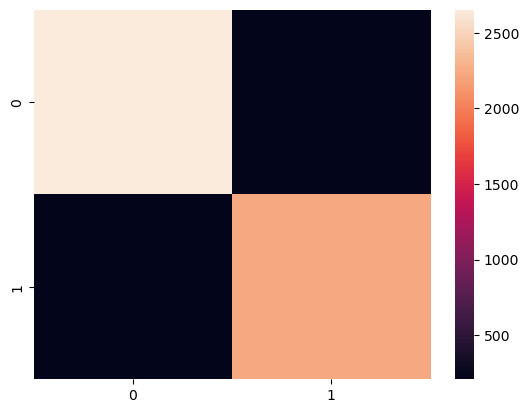

[[2653  209]
 [ 214 2242]]
roc_auc: 0.9199202967333383 Accuracy: 0.9204588191049267 f1: 0.9137966170776441 recall: 0.9128664495114006 precision: 0.9147286821705426


In [19]:
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

# best

In [59]:
# 
train_pool = Pool(X_train[:-5000],label = Y_train[:-5000],cat_features = col)
eval_pool = Pool(X_train[-5000:],label = Y_train[-5000:],cat_features = col)
test_pool = Pool(X_test,cat_features = col)

params = {
    'iterations': 2000,
    'learning_rate': 0.02,
    'depth': 8,
    'early_stopping_rounds': 30,
    'loss_function':"Logloss",
    'od_type':"Iter",
    'class_weights':[1, 1.07],
    'eval_metric':'Accuracy'
    
}
model = CatBoostClassifier(**params)

model.fit(train_pool,eval_set=eval_pool)

0:	learn: 0.6883129	test: 0.6761204	best: 0.6761204 (0)	total: 1.17s	remaining: 38m 56s
1:	learn: 0.7219967	test: 0.7108630	best: 0.7108630 (1)	total: 2.31s	remaining: 38m 33s
2:	learn: 0.7271291	test: 0.7186789	best: 0.7186789 (2)	total: 3.47s	remaining: 38m 32s
3:	learn: 0.7451187	test: 0.7372457	best: 0.7372457 (3)	total: 4.63s	remaining: 38m 29s
4:	learn: 0.7405719	test: 0.7374703	best: 0.7374703 (4)	total: 5.81s	remaining: 38m 37s
5:	learn: 0.7630899	test: 0.7609392	best: 0.7609392 (5)	total: 7.4s	remaining: 40m 59s
6:	learn: 0.7617721	test: 0.7584127	best: 0.7609392 (5)	total: 8.53s	remaining: 40m 28s
7:	learn: 0.7670763	test: 0.7653438	best: 0.7653438 (7)	total: 9.66s	remaining: 40m 6s
8:	learn: 0.7715439	test: 0.7674057	best: 0.7674057 (8)	total: 10.8s	remaining: 39m 53s
9:	learn: 0.7712240	test: 0.7659923	best: 0.7674057 (8)	total: 11.9s	remaining: 39m 36s
10:	learn: 0.7705623	test: 0.7666990	best: 0.7674057 (8)	total: 13.5s	remaining: 40m 45s
11:	learn: 0.7776286	test: 0.7707

92:	learn: 0.8371540	test: 0.8268524	best: 0.8268524 (92)	total: 1m 52s	remaining: 38m 29s
93:	learn: 0.8380931	test: 0.8270595	best: 0.8270595 (93)	total: 1m 53s	remaining: 38m 26s
94:	learn: 0.8389999	test: 0.8277217	best: 0.8277217 (94)	total: 1m 54s	remaining: 38m 23s
95:	learn: 0.8390479	test: 0.8279017	best: 0.8279017 (95)	total: 1m 56s	remaining: 38m 28s
96:	learn: 0.8410066	test: 0.8301398	best: 0.8301398 (96)	total: 1m 57s	remaining: 38m 24s
97:	learn: 0.8417728	test: 0.8307206	best: 0.8307206 (97)	total: 1m 58s	remaining: 38m 22s
98:	learn: 0.8422534	test: 0.8321165	best: 0.8321165 (98)	total: 1m 59s	remaining: 38m 19s
99:	learn: 0.8428997	test: 0.8321165	best: 0.8321165 (98)	total: 2m	remaining: 38m 16s
100:	learn: 0.8427580	test: 0.8323372	best: 0.8323372 (100)	total: 2m 2s	remaining: 38m 21s
101:	learn: 0.8430178	test: 0.8327244	best: 0.8327244 (101)	total: 2m 3s	remaining: 38m 18s
102:	learn: 0.8436623	test: 0.8327109	best: 0.8327244 (101)	total: 2m 4s	remaining: 38m 15s


181:	learn: 0.8745133	test: 0.8628534	best: 0.8628534 (181)	total: 3m 40s	remaining: 36m 43s
182:	learn: 0.8748320	test: 0.8630335	best: 0.8630335 (182)	total: 3m 41s	remaining: 36m 41s
183:	learn: 0.8746369	test: 0.8630741	best: 0.8630741 (183)	total: 3m 42s	remaining: 36m 38s
184:	learn: 0.8750972	test: 0.8636549	best: 0.8636549 (184)	total: 3m 43s	remaining: 36m 36s
185:	learn: 0.8754836	test: 0.8646907	best: 0.8646907 (185)	total: 3m 45s	remaining: 36m 38s
186:	learn: 0.8758737	test: 0.8649114	best: 0.8649114 (186)	total: 3m 46s	remaining: 36m 36s
187:	learn: 0.8761023	test: 0.8647043	best: 0.8649114 (186)	total: 3m 47s	remaining: 36m 34s
188:	learn: 0.8765367	test: 0.8648979	best: 0.8649114 (186)	total: 3m 48s	remaining: 36m 32s
189:	learn: 0.8765811	test: 0.8653393	best: 0.8653393 (189)	total: 3m 50s	remaining: 36m 31s
190:	learn: 0.8770636	test: 0.8659608	best: 0.8659608 (190)	total: 3m 51s	remaining: 36m 33s
191:	learn: 0.8774722	test: 0.8657401	best: 0.8659608 (190)	total: 3m 

270:	learn: 0.8940209	test: 0.8811221	best: 0.8811356 (269)	total: 5m 32s	remaining: 35m 22s
271:	learn: 0.8945196	test: 0.8819507	best: 0.8819507 (271)	total: 5m 33s	remaining: 35m 21s
272:	learn: 0.8943816	test: 0.8821579	best: 0.8821579 (272)	total: 5m 35s	remaining: 35m 20s
273:	learn: 0.8946006	test: 0.8821443	best: 0.8821579 (272)	total: 5m 36s	remaining: 35m 18s
274:	learn: 0.8946300	test: 0.8827251	best: 0.8827251 (274)	total: 5m 37s	remaining: 35m 17s
275:	learn: 0.8947608	test: 0.8819236	best: 0.8827251 (274)	total: 5m 39s	remaining: 35m 18s
276:	learn: 0.8950224	test: 0.8819100	best: 0.8827251 (274)	total: 5m 40s	remaining: 35m 16s
277:	learn: 0.8949966	test: 0.8829187	best: 0.8829187 (277)	total: 5m 41s	remaining: 35m 15s
278:	learn: 0.8952324	test: 0.8835266	best: 0.8835266 (278)	total: 5m 42s	remaining: 35m 13s
279:	learn: 0.8954388	test: 0.8833195	best: 0.8835266 (278)	total: 5m 43s	remaining: 35m 12s
280:	learn: 0.8958756	test: 0.8823108	best: 0.8835266 (278)	total: 5m 

359:	learn: 0.9074131	test: 0.8946938	best: 0.8948874 (358)	total: 7m 24s	remaining: 33m 45s
360:	learn: 0.9076398	test: 0.8948739	best: 0.8948874 (358)	total: 7m 26s	remaining: 33m 46s
361:	learn: 0.9077598	test: 0.8942660	best: 0.8948874 (358)	total: 7m 27s	remaining: 33m 44s
362:	learn: 0.9078942	test: 0.8944596	best: 0.8948874 (358)	total: 7m 28s	remaining: 33m 43s
363:	learn: 0.9078042	test: 0.8948739	best: 0.8948874 (358)	total: 7m 29s	remaining: 33m 41s
364:	learn: 0.9078042	test: 0.8950811	best: 0.8950811 (364)	total: 7m 30s	remaining: 33m 39s
365:	learn: 0.9081576	test: 0.8954954	best: 0.8954954 (365)	total: 7m 32s	remaining: 33m 39s
366:	learn: 0.9081174	test: 0.8954818	best: 0.8954954 (365)	total: 7m 33s	remaining: 33m 38s
367:	learn: 0.9082242	test: 0.8958690	best: 0.8958690 (367)	total: 7m 34s	remaining: 33m 36s
368:	learn: 0.9083754	test: 0.8962698	best: 0.8962698 (368)	total: 7m 35s	remaining: 33m 35s
369:	learn: 0.9084894	test: 0.8964770	best: 0.8964770 (369)	total: 7m 

448:	learn: 0.9157425	test: 0.9020334	best: 0.9022406 (447)	total: 9m 14s	remaining: 31m 54s
449:	learn: 0.9160059	test: 0.9026143	best: 0.9026143 (449)	total: 9m 15s	remaining: 31m 52s
450:	learn: 0.9163245	test: 0.9024207	best: 0.9026143 (449)	total: 9m 16s	remaining: 31m 52s
451:	learn: 0.9163539	test: 0.9022270	best: 0.9026143 (449)	total: 9m 17s	remaining: 31m 50s
452:	learn: 0.9162951	test: 0.9022406	best: 0.9026143 (449)	total: 9m 19s	remaining: 31m 49s
453:	learn: 0.9163521	test: 0.9024342	best: 0.9026143 (449)	total: 9m 20s	remaining: 31m 47s
454:	learn: 0.9164349	test: 0.9024342	best: 0.9026143 (449)	total: 9m 21s	remaining: 31m 46s
455:	learn: 0.9165711	test: 0.9026278	best: 0.9026278 (455)	total: 9m 22s	remaining: 31m 46s
456:	learn: 0.9167205	test: 0.9030286	best: 0.9030286 (456)	total: 9m 24s	remaining: 31m 44s
457:	learn: 0.9166947	test: 0.9030286	best: 0.9030286 (456)	total: 9m 25s	remaining: 31m 43s
458:	learn: 0.9168789	test: 0.9028214	best: 0.9030286 (456)	total: 9m 

536:	learn: 0.9219745	test: 0.9067613	best: 0.9081843 (528)	total: 11m	remaining: 30m
537:	learn: 0.9218935	test: 0.9065677	best: 0.9081843 (528)	total: 11m 2s	remaining: 29m 59s
538:	learn: 0.9218088	test: 0.9065677	best: 0.9081843 (528)	total: 11m 3s	remaining: 29m 57s
539:	learn: 0.9218640	test: 0.9065677	best: 0.9081843 (528)	total: 11m 4s	remaining: 29m 56s
540:	learn: 0.9218916	test: 0.9071756	best: 0.9081843 (528)	total: 11m 5s	remaining: 29m 55s
541:	learn: 0.9219138	test: 0.9075628	best: 0.9081843 (528)	total: 11m 6s	remaining: 29m 54s
542:	learn: 0.9219727	test: 0.9073692	best: 0.9081843 (528)	total: 11m 8s	remaining: 29m 52s
543:	learn: 0.9218880	test: 0.9069549	best: 0.9081843 (528)	total: 11m 9s	remaining: 29m 51s
544:	learn: 0.9219672	test: 0.9067613	best: 0.9081843 (528)	total: 11m 10s	remaining: 29m 49s
545:	learn: 0.9219763	test: 0.9073557	best: 0.9081843 (528)	total: 11m 11s	remaining: 29m 49s
546:	learn: 0.9223777	test: 0.9075628	best: 0.9081843 (528)	total: 11m 13s	

624:	learn: 0.9289151	test: 0.9123991	best: 0.9123991 (624)	total: 12m 46s	remaining: 28m 6s
625:	learn: 0.9289685	test: 0.9123991	best: 0.9123991 (624)	total: 12m 48s	remaining: 28m 6s
626:	learn: 0.9290550	test: 0.9126063	best: 0.9126063 (626)	total: 12m 49s	remaining: 28m 4s
627:	learn: 0.9292962	test: 0.9128134	best: 0.9128134 (627)	total: 12m 50s	remaining: 28m 3s
628:	learn: 0.9293016	test: 0.9126198	best: 0.9128134 (627)	total: 12m 51s	remaining: 28m 1s
629:	learn: 0.9293202	test: 0.9127999	best: 0.9128134 (627)	total: 12m 52s	remaining: 28m
630:	learn: 0.9294750	test: 0.9127728	best: 0.9128134 (627)	total: 12m 54s	remaining: 27m 59s
631:	learn: 0.9294179	test: 0.9123720	best: 0.9128134 (627)	total: 12m 55s	remaining: 27m 58s
632:	learn: 0.9293772	test: 0.9121784	best: 0.9128134 (627)	total: 12m 56s	remaining: 27m 56s
633:	learn: 0.9292686	test: 0.9127728	best: 0.9128134 (627)	total: 12m 57s	remaining: 27m 55s
634:	learn: 0.9293460	test: 0.9131735	best: 0.9131735 (634)	total: 12

712:	learn: 0.9349964	test: 0.9175006	best: 0.9187165 (701)	total: 14m 33s	remaining: 26m 15s
713:	learn: 0.9350498	test: 0.9177078	best: 0.9187165 (701)	total: 14m 34s	remaining: 26m 14s
714:	learn: 0.9349964	test: 0.9179149	best: 0.9187165 (701)	total: 14m 35s	remaining: 26m 13s
715:	learn: 0.9351290	test: 0.9177078	best: 0.9187165 (701)	total: 14m 36s	remaining: 26m 12s
716:	learn: 0.9352634	test: 0.9177078	best: 0.9187165 (701)	total: 14m 37s	remaining: 26m 10s
717:	learn: 0.9352580	test: 0.9179149	best: 0.9187165 (701)	total: 14m 39s	remaining: 26m 9s
718:	learn: 0.9353390	test: 0.9179149	best: 0.9187165 (701)	total: 14m 40s	remaining: 26m 8s
719:	learn: 0.9353132	test: 0.9181221	best: 0.9187165 (701)	total: 14m 41s	remaining: 26m 6s
720:	learn: 0.9352580	test: 0.9179149	best: 0.9187165 (701)	total: 14m 42s	remaining: 26m 6s
721:	learn: 0.9353906	test: 0.9187029	best: 0.9187165 (701)	total: 14m 43s	remaining: 26m 4s
722:	learn: 0.9354422	test: 0.9184958	best: 0.9187165 (701)	total

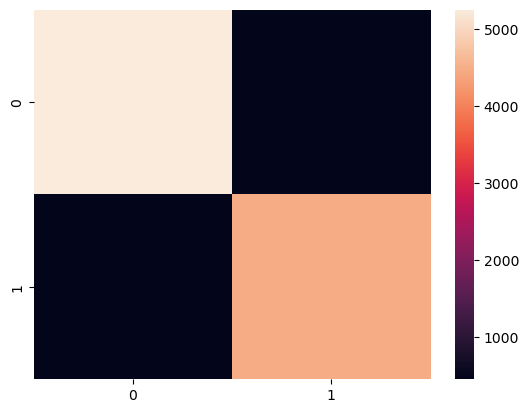

[[5249  467]
 [ 450 4469]]
roc_auc: 0.9134087508043175 Accuracy: 0.9137752703338035 f1: 0.9069507864028413 recall: 0.9085179914616792 precision: 0.9053889789303079


In [60]:
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

# 5

In [22]:
params = {
    'iterations': 2000,
    'learning_rate': 0.02,
    'depth': 6,
    'early_stopping_rounds': 30,
    'loss_function':"Logloss",
    'od_type':"Iter",
    'class_weights':[1, 1.075],
    'eval_metric':'Accuracy'
    
}
model = CatBoostClassifier(**params)

model.fit(train_pool,eval_set=eval_pool)

0:	learn: 0.6456282	test: 0.6454894	best: 0.6454894 (0)	total: 504ms	remaining: 16m 47s
1:	learn: 0.6628862	test: 0.6701662	best: 0.6701662 (1)	total: 967ms	remaining: 16m 5s
2:	learn: 0.6814666	test: 0.6793125	best: 0.6793125 (2)	total: 1.43s	remaining: 15m 51s
3:	learn: 0.6895218	test: 0.6809931	best: 0.6809931 (3)	total: 1.9s	remaining: 15m 46s
4:	learn: 0.6928120	test: 0.6901732	best: 0.6901732 (4)	total: 2.37s	remaining: 15m 45s
5:	learn: 0.6972263	test: 0.7022026	best: 0.7022026 (5)	total: 2.83s	remaining: 15m 42s
6:	learn: 0.6942934	test: 0.6929451	best: 0.7022026 (5)	total: 3.31s	remaining: 15m 41s
7:	learn: 0.7014010	test: 0.7009373	best: 0.7022026 (5)	total: 3.9s	remaining: 16m 10s
8:	learn: 0.7032291	test: 0.7014396	best: 0.7022026 (5)	total: 4.38s	remaining: 16m 9s
9:	learn: 0.7037555	test: 0.7029849	best: 0.7029849 (9)	total: 4.82s	remaining: 15m 59s
10:	learn: 0.7121540	test: 0.7101513	best: 0.7101513 (10)	total: 5.27s	remaining: 15m 52s
11:	learn: 0.7122769	test: 0.71094

92:	learn: 0.7770733	test: 0.7723794	best: 0.7734611 (86)	total: 45.3s	remaining: 15m 28s
93:	learn: 0.7778647	test: 0.7732100	best: 0.7734611 (86)	total: 45.7s	remaining: 15m 27s
94:	learn: 0.7797508	test: 0.7761171	best: 0.7761171 (94)	total: 46.2s	remaining: 15m 26s
95:	learn: 0.7815529	test: 0.7764889	best: 0.7764889 (95)	total: 46.7s	remaining: 15m 25s
96:	learn: 0.7827852	test: 0.7779570	best: 0.7779570 (96)	total: 47.1s	remaining: 15m 23s
97:	learn: 0.7835084	test: 0.7769477	best: 0.7779570 (96)	total: 47.6s	remaining: 15m 23s
98:	learn: 0.7838449	test: 0.7761026	best: 0.7779570 (96)	total: 48.2s	remaining: 15m 25s
99:	learn: 0.7848111	test: 0.7773340	best: 0.7779570 (96)	total: 48.7s	remaining: 15m 24s
100:	learn: 0.7847536	test: 0.7769332	best: 0.7779570 (96)	total: 49.2s	remaining: 15m 24s
101:	learn: 0.7857434	test: 0.7783143	best: 0.7783143 (101)	total: 49.6s	remaining: 15m 23s
102:	learn: 0.7854441	test: 0.7785220	best: 0.7785220 (102)	total: 50.1s	remaining: 15m 22s
103:	

182:	learn: 0.8180351	test: 0.8120023	best: 0.8120023 (182)	total: 1m 28s	remaining: 14m 43s
183:	learn: 0.8194128	test: 0.8142430	best: 0.8142430 (183)	total: 1m 29s	remaining: 14m 42s
184:	learn: 0.8195481	test: 0.8132337	best: 0.8142430 (183)	total: 1m 29s	remaining: 14m 42s
185:	learn: 0.8197172	test: 0.8128619	best: 0.8142430 (183)	total: 1m 30s	remaining: 14m 41s
186:	learn: 0.8200413	test: 0.8126542	best: 0.8142430 (183)	total: 1m 30s	remaining: 14m 40s
187:	learn: 0.8201800	test: 0.8130550	best: 0.8142430 (183)	total: 1m 31s	remaining: 14m 39s
188:	learn: 0.8203293	test: 0.8133834	best: 0.8142430 (183)	total: 1m 31s	remaining: 14m 39s
189:	learn: 0.8211123	test: 0.8129826	best: 0.8142430 (183)	total: 1m 32s	remaining: 14m 40s
190:	learn: 0.8218941	test: 0.8144217	best: 0.8144217 (190)	total: 1m 32s	remaining: 14m 39s
191:	learn: 0.8221044	test: 0.8154165	best: 0.8154165 (191)	total: 1m 33s	remaining: 14m 38s
192:	learn: 0.8225599	test: 0.8154020	best: 0.8154165 (191)	total: 1m 

271:	learn: 0.8407079	test: 0.8311208	best: 0.8313574 (268)	total: 2m 11s	remaining: 13m 55s
272:	learn: 0.8409819	test: 0.8313140	best: 0.8313574 (268)	total: 2m 12s	remaining: 13m 55s
273:	learn: 0.8407688	test: 0.8309421	best: 0.8313574 (268)	total: 2m 12s	remaining: 13m 55s
274:	learn: 0.8408449	test: 0.8307489	best: 0.8313574 (268)	total: 2m 13s	remaining: 13m 54s
275:	learn: 0.8410304	test: 0.8313574	best: 0.8313574 (268)	total: 2m 13s	remaining: 13m 54s
276:	learn: 0.8409977	test: 0.8307489	best: 0.8313574 (268)	total: 2m 14s	remaining: 13m 53s
277:	learn: 0.8408883	test: 0.8307200	best: 0.8313574 (268)	total: 2m 14s	remaining: 13m 52s
278:	learn: 0.8409684	test: 0.8313140	best: 0.8313574 (268)	total: 2m 14s	remaining: 13m 52s
279:	learn: 0.8410879	test: 0.8311208	best: 0.8313574 (268)	total: 2m 15s	remaining: 13m 51s
280:	learn: 0.8410929	test: 0.8307345	best: 0.8313574 (268)	total: 2m 15s	remaining: 13m 51s
281:	learn: 0.8415033	test: 0.8319659	best: 0.8319659 (281)	total: 2m 

360:	learn: 0.8573966	test: 0.8464388	best: 0.8464388 (360)	total: 2m 54s	remaining: 13m 11s
361:	learn: 0.8575871	test: 0.8464388	best: 0.8464388 (360)	total: 2m 54s	remaining: 13m 10s
362:	learn: 0.8578938	test: 0.8464388	best: 0.8464388 (360)	total: 2m 55s	remaining: 13m 10s
363:	learn: 0.8579857	test: 0.8460235	best: 0.8464388 (360)	total: 2m 55s	remaining: 13m 9s
364:	learn: 0.8581593	test: 0.8454005	best: 0.8464388 (360)	total: 2m 56s	remaining: 13m 9s
365:	learn: 0.8581784	test: 0.8456082	best: 0.8464388 (360)	total: 2m 56s	remaining: 13m 8s
366:	learn: 0.8582044	test: 0.8445989	best: 0.8464388 (360)	total: 2m 57s	remaining: 13m 8s
367:	learn: 0.8584558	test: 0.8445844	best: 0.8464388 (360)	total: 2m 57s	remaining: 13m 7s
368:	learn: 0.8584276	test: 0.8456371	best: 0.8464388 (360)	total: 2m 58s	remaining: 13m 7s
369:	learn: 0.8588402	test: 0.8456371	best: 0.8464388 (360)	total: 2m 58s	remaining: 13m 6s
370:	learn: 0.8590460	test: 0.8458593	best: 0.8464388 (360)	total: 2m 58s	rem

449:	learn: 0.8689827	test: 0.8548076	best: 0.8548076 (449)	total: 3m 36s	remaining: 12m 27s
450:	learn: 0.8691992	test: 0.8551940	best: 0.8551940 (450)	total: 3m 37s	remaining: 12m 26s
451:	learn: 0.8692167	test: 0.8549863	best: 0.8551940 (450)	total: 3m 37s	remaining: 12m 25s
452:	learn: 0.8691332	test: 0.8547931	best: 0.8551940 (450)	total: 3m 38s	remaining: 12m 25s
453:	learn: 0.8691766	test: 0.8551795	best: 0.8551940 (450)	total: 3m 38s	remaining: 12m 24s
454:	learn: 0.8692860	test: 0.8553871	best: 0.8553871 (454)	total: 3m 39s	remaining: 12m 24s
455:	learn: 0.8695509	test: 0.8553871	best: 0.8553871 (454)	total: 3m 39s	remaining: 12m 24s
456:	learn: 0.8694072	test: 0.8553871	best: 0.8553871 (454)	total: 3m 40s	remaining: 12m 23s
457:	learn: 0.8695701	test: 0.8555803	best: 0.8555803 (457)	total: 3m 40s	remaining: 12m 23s
458:	learn: 0.8695216	test: 0.8555803	best: 0.8555803 (457)	total: 3m 41s	remaining: 12m 22s
459:	learn: 0.8697296	test: 0.8554016	best: 0.8555803 (457)	total: 3m 

538:	learn: 0.8815604	test: 0.8683340	best: 0.8683340 (538)	total: 4m 19s	remaining: 11m 43s
539:	learn: 0.8817058	test: 0.8683340	best: 0.8683340 (538)	total: 4m 20s	remaining: 11m 43s
540:	learn: 0.8816957	test: 0.8679477	best: 0.8683340 (538)	total: 4m 20s	remaining: 11m 43s
541:	learn: 0.8819849	test: 0.8685417	best: 0.8685417 (541)	total: 4m 21s	remaining: 11m 42s
542:	learn: 0.8821044	test: 0.8691067	best: 0.8691067 (542)	total: 4m 21s	remaining: 11m 42s
543:	learn: 0.8822898	test: 0.8693143	best: 0.8693143 (543)	total: 4m 22s	remaining: 11m 41s
544:	learn: 0.8822571	test: 0.8693143	best: 0.8693143 (543)	total: 4m 22s	remaining: 11m 40s
545:	learn: 0.8822639	test: 0.8695075	best: 0.8695075 (545)	total: 4m 23s	remaining: 11m 40s
546:	learn: 0.8827751	test: 0.8701304	best: 0.8701304 (546)	total: 4m 23s	remaining: 11m 40s
547:	learn: 0.8827176	test: 0.8697296	best: 0.8701304 (546)	total: 4m 24s	remaining: 11m 39s
548:	learn: 0.8827994	test: 0.8693433	best: 0.8701304 (546)	total: 4m 

627:	learn: 0.8927266	test: 0.8773451	best: 0.8773451 (627)	total: 5m 2s	remaining: 11m
628:	learn: 0.8930766	test: 0.8779391	best: 0.8779391 (628)	total: 5m 2s	remaining: 11m
629:	learn: 0.8930783	test: 0.8783544	best: 0.8783544 (629)	total: 5m 3s	remaining: 10m 59s
630:	learn: 0.8932012	test: 0.8783399	best: 0.8783544 (629)	total: 5m 4s	remaining: 10m 59s
631:	learn: 0.8935355	test: 0.8785476	best: 0.8785476 (631)	total: 5m 4s	remaining: 10m 59s
632:	learn: 0.8934193	test: 0.8785476	best: 0.8785476 (631)	total: 5m 4s	remaining: 10m 58s
633:	learn: 0.8936967	test: 0.8789484	best: 0.8789484 (633)	total: 5m 5s	remaining: 10m 58s
634:	learn: 0.8936031	test: 0.8787552	best: 0.8789484 (633)	total: 5m 5s	remaining: 10m 57s
635:	learn: 0.8936116	test: 0.8787552	best: 0.8789484 (633)	total: 5m 6s	remaining: 10m 57s
636:	learn: 0.8938263	test: 0.8787552	best: 0.8789484 (633)	total: 5m 6s	remaining: 10m 56s
637:	learn: 0.8937277	test: 0.8785476	best: 0.8789484 (633)	total: 5m 7s	remaining: 10m 

716:	learn: 0.9002502	test: 0.8894276	best: 0.8898429 (715)	total: 5m 45s	remaining: 10m 18s
717:	learn: 0.9004339	test: 0.8894276	best: 0.8898429 (715)	total: 5m 45s	remaining: 10m 17s
718:	learn: 0.9004948	test: 0.8894276	best: 0.8898429 (715)	total: 5m 46s	remaining: 10m 16s
719:	learn: 0.9004322	test: 0.8894276	best: 0.8898429 (715)	total: 5m 46s	remaining: 10m 16s
720:	learn: 0.9005968	test: 0.8896497	best: 0.8898429 (715)	total: 5m 47s	remaining: 10m 15s
721:	learn: 0.9005968	test: 0.8898284	best: 0.8898429 (715)	total: 5m 47s	remaining: 10m 15s
722:	learn: 0.9007180	test: 0.8898429	best: 0.8898429 (715)	total: 5m 48s	remaining: 10m 15s
723:	learn: 0.9005326	test: 0.8892200	best: 0.8898429 (715)	total: 5m 48s	remaining: 10m 14s
724:	learn: 0.9005827	test: 0.8898284	best: 0.8898429 (715)	total: 5m 49s	remaining: 10m 14s
725:	learn: 0.9008725	test: 0.8900071	best: 0.8900071 (725)	total: 5m 49s	remaining: 10m 13s
726:	learn: 0.9007006	test: 0.8908087	best: 0.8908087 (726)	total: 5m 

806:	learn: 0.9072208	test: 0.8954882	best: 0.8963188 (802)	total: 6m 28s	remaining: 9m 34s
807:	learn: 0.9072952	test: 0.8956813	best: 0.8963188 (802)	total: 6m 28s	remaining: 9m 33s
808:	learn: 0.9072050	test: 0.8958745	best: 0.8963188 (802)	total: 6m 29s	remaining: 9m 33s
809:	learn: 0.9072450	test: 0.8962753	best: 0.8963188 (802)	total: 6m 29s	remaining: 9m 32s
810:	learn: 0.9076436	test: 0.8962753	best: 0.8963188 (802)	total: 6m 30s	remaining: 9m 32s
811:	learn: 0.9076746	test: 0.8964830	best: 0.8964830 (811)	total: 6m 30s	remaining: 9m 31s
812:	learn: 0.9077873	test: 0.8966761	best: 0.8966761 (812)	total: 6m 31s	remaining: 9m 31s
813:	learn: 0.9078341	test: 0.8966761	best: 0.8966761 (812)	total: 6m 31s	remaining: 9m 30s
814:	learn: 0.9079102	test: 0.8968983	best: 0.8968983 (814)	total: 6m 32s	remaining: 9m 30s
815:	learn: 0.9079085	test: 0.8966906	best: 0.8968983 (814)	total: 6m 32s	remaining: 9m 29s
816:	learn: 0.9080438	test: 0.8966906	best: 0.8968983 (814)	total: 6m 33s	remain

896:	learn: 0.9129062	test: 0.9009982	best: 0.9009982 (884)	total: 7m 11s	remaining: 8m 50s
897:	learn: 0.9128836	test: 0.9009982	best: 0.9009982 (884)	total: 7m 12s	remaining: 8m 50s
898:	learn: 0.9129237	test: 0.9007905	best: 0.9009982 (884)	total: 7m 12s	remaining: 8m 49s
899:	learn: 0.9130398	test: 0.9009837	best: 0.9009982 (884)	total: 7m 13s	remaining: 8m 49s
900:	learn: 0.9131142	test: 0.9007905	best: 0.9009982 (884)	total: 7m 13s	remaining: 8m 48s
901:	learn: 0.9130883	test: 0.9007905	best: 0.9009982 (884)	total: 7m 13s	remaining: 8m 48s
902:	learn: 0.9129981	test: 0.9005829	best: 0.9009982 (884)	total: 7m 14s	remaining: 8m 47s
903:	learn: 0.9132320	test: 0.9009692	best: 0.9009982 (884)	total: 7m 14s	remaining: 8m 47s
904:	learn: 0.9132855	test: 0.9007760	best: 0.9009982 (884)	total: 7m 15s	remaining: 8m 46s
905:	learn: 0.9133098	test: 0.9011913	best: 0.9011913 (905)	total: 7m 15s	remaining: 8m 46s
906:	learn: 0.9135178	test: 0.9009837	best: 0.9011913 (905)	total: 7m 16s	remain

986:	learn: 0.9170662	test: 0.9061943	best: 0.9067738 (985)	total: 7m 54s	remaining: 8m 6s
987:	learn: 0.9170628	test: 0.9067738	best: 0.9067738 (985)	total: 7m 54s	remaining: 8m 6s
988:	learn: 0.9172759	test: 0.9065662	best: 0.9067738 (985)	total: 7m 55s	remaining: 8m 5s
989:	learn: 0.9172100	test: 0.9065806	best: 0.9067738 (985)	total: 7m 55s	remaining: 8m 5s
990:	learn: 0.9173486	test: 0.9065806	best: 0.9067738 (985)	total: 7m 56s	remaining: 8m 4s
991:	learn: 0.9174681	test: 0.9065806	best: 0.9067738 (985)	total: 7m 56s	remaining: 8m 4s
992:	learn: 0.9176897	test: 0.9065951	best: 0.9067738 (985)	total: 7m 57s	remaining: 8m 3s
993:	learn: 0.9179670	test: 0.9067883	best: 0.9067883 (993)	total: 7m 57s	remaining: 8m 3s
994:	learn: 0.9180138	test: 0.9069815	best: 0.9069815 (994)	total: 7m 58s	remaining: 8m 3s
995:	learn: 0.9177799	test: 0.9066096	best: 0.9069815 (994)	total: 7m 58s	remaining: 8m 2s
996:	learn: 0.9178734	test: 0.9064020	best: 0.9069815 (994)	total: 7m 59s	remaining: 8m 2s

1075:	learn: 0.9208666	test: 0.9083481	best: 0.9087634 (1065)	total: 8m 36s	remaining: 7m 23s
1076:	learn: 0.9209619	test: 0.9087634	best: 0.9087634 (1065)	total: 8m 37s	remaining: 7m 23s
1077:	learn: 0.9210814	test: 0.9093429	best: 0.9093429 (1077)	total: 8m 37s	remaining: 7m 22s
1078:	learn: 0.9211265	test: 0.9091497	best: 0.9093429 (1077)	total: 8m 38s	remaining: 7m 22s
1079:	learn: 0.9212460	test: 0.9093574	best: 0.9093574 (1079)	total: 8m 38s	remaining: 7m 21s
1080:	learn: 0.9211541	test: 0.9095506	best: 0.9095506 (1080)	total: 8m 39s	remaining: 7m 21s
1081:	learn: 0.9213430	test: 0.9097582	best: 0.9097582 (1081)	total: 8m 39s	remaining: 7m 20s
1082:	learn: 0.9214574	test: 0.9099514	best: 0.9099514 (1082)	total: 8m 39s	remaining: 7m 20s
1083:	learn: 0.9214072	test: 0.9099369	best: 0.9099514 (1082)	total: 8m 40s	remaining: 7m 19s
1084:	learn: 0.9216220	test: 0.9099369	best: 0.9099514 (1082)	total: 8m 40s	remaining: 7m 19s
1085:	learn: 0.9215718	test: 0.9097292	best: 0.9099514 (1082

1163:	learn: 0.9244878	test: 0.9125639	best: 0.9127716 (1159)	total: 9m 18s	remaining: 6m 41s
1164:	learn: 0.9244185	test: 0.9125639	best: 0.9127716 (1159)	total: 9m 19s	remaining: 6m 40s
1165:	learn: 0.9245864	test: 0.9125639	best: 0.9127716 (1159)	total: 9m 19s	remaining: 6m 40s
1166:	learn: 0.9246039	test: 0.9119410	best: 0.9127716 (1159)	total: 9m 20s	remaining: 6m 39s
1167:	learn: 0.9246073	test: 0.9117333	best: 0.9127716 (1159)	total: 9m 20s	remaining: 6m 39s
1168:	learn: 0.9246332	test: 0.9121486	best: 0.9127716 (1159)	total: 9m 21s	remaining: 6m 38s
1169:	learn: 0.9246575	test: 0.9117333	best: 0.9127716 (1159)	total: 9m 21s	remaining: 6m 38s
1170:	learn: 0.9247285	test: 0.9119410	best: 0.9127716 (1159)	total: 9m 22s	remaining: 6m 38s
1171:	learn: 0.9247285	test: 0.9119410	best: 0.9127716 (1159)	total: 9m 22s	remaining: 6m 37s
1172:	learn: 0.9246766	test: 0.9117478	best: 0.9127716 (1159)	total: 9m 23s	remaining: 6m 37s
1173:	learn: 0.9246992	test: 0.9115402	best: 0.9127716 (1159

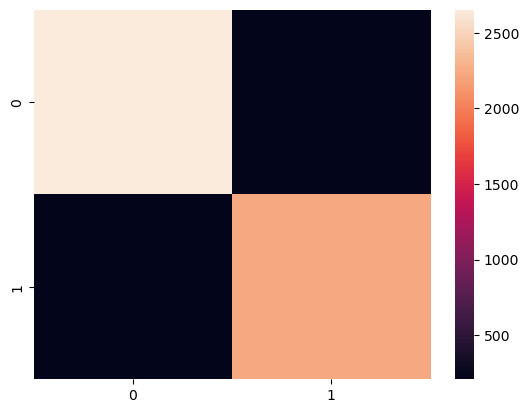

[[2653  209]
 [ 214 2242]]
roc_auc: 0.9199202967333383 Accuracy: 0.9204588191049267 f1: 0.9137966170776441 recall: 0.9128664495114006 precision: 0.9147286821705426


In [23]:
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

# 测试

In [61]:
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows', None)  # 设置显示最大
data = pd.read_csv("D:/propycharm2023/mq5/KDATA_type_1011.csv")
data = data.drop(['Unnamed: 0', '时间','volume','订单规定价格', '订单ID', '当前价格', 'profit', '类型',
                  'fractals_up_arrow_1D_bin', 'fractals_up_arrow', 'fractals_up_arrow_15M_bin',
          'fractals_up_arrow_30M_bin', 'fractals_up_arrow_1H_bin',
         'fractals_down_arrow_1D_bin', 'fractals_down_arrow', 'fractals_down_arrow_15M_bin',
          'fractals_down_arrow_30M_bin', 'fractals_down_arrow_1H_bin', 'pass5', 'pass10', 'pass100'], axis=1, inplace=False)
data = data.dropna(axis=0)
print(data.shape)
data.describe()


(1136, 6486)


open_price         high          low        close  open_change1  \
count  1136.000000  1136.000000  1136.000000  1136.000000   1136.000000   
mean   1891.018688  1891.535335  1890.547562  1891.068134      0.002454   
std      23.147542    23.213729    23.062911    23.134127      0.043442   
min    1858.860000  1859.300000  1858.610000  1858.840000     -0.316600   
25%    1871.935000  1872.595000  1871.477500  1871.940000     -0.017625   
50%    1880.140000  1880.495000  1879.565000  1880.175000      0.002100   
75%    1917.480000  1918.252500  1916.797500  1917.462500      0.020825   
max    1929.510000  1930.330000  1929.510000  1929.600000      0.586900   

       open_change2  open_change3  open_change4  open_change5  open_change6  \
count   1136.000000   1136.000000   1136.000000   1136.000000   1136.000000   
mean       0.002359      0.002700      0.002773      0.002485      0.002085   
std        0.043111      0.042969      0.037970      0.036864      0.036112   
min       -0.316600     -0.316600     -0.186600     -0.186600     -0.186600   
25%       -0.017625     -0.017525     -0.017275     -0.017275     -0.017700   
50%        0.001850      0.002100      0.002100      0.002100      0.001600   
75%        0.020800      0.020800      0.020800      0.020800      0.020500   
max        0.586900      0.586900      0.305400      0.280000      0.176500   

       open_change7  open_change8  open_change9  open_change10  open_change11  \
count   1136.000000   1136.000000   1136.000000    1136.000000     1136.00000   
mean       0.001955      0.001844      0.001732       0.001510        0.00151   
std        0.036039      0.036017      0.035988       0.035967        0.03590   
min       -0.186600     -0.186600     -0.186600      -0.186600       -0.18660   
25%       -0.017700     -0.017700     -0.017700      -0.018125       -0.01780   
50%        0.001600      0.001600      0.001600       0.001600        0.00160   
75%        0.020300      0.020300      0.020300       0.019825        0.01980   
max        0.176500      0.176500      0.176500       0.176500        0.17650   

       open_change12  open_change13  open_change14  open_change15  \
count    1136.000000    1136.000000    1136.000000    1136.000000   
mean        0.001512       0.001562       0.001588       0.001534   
std         0.035599       0.035628       0.035629       0.035510   
min        -0.186600      -0.186600      -0.186600      -0.186600   
25%        -0.017700      -0.017700      -0.017700      -0.017700   
50%         0.001350       0.001600       0.001600       0.001600   
75%         0.019825       0.020000       0.020000       0.019825   
max         0.176500       0.176500       0.176500       0.176500   

       open_change16  open_change17  open_change18  open_change19  \
count    1136.000000    1136.000000    1136.000000    1136.000000   
mean        0.001467       0.001419       0.001016       0.001082   
std         0.035648       0.035964       0.036602       0.036599   
min        -0.186600      -0.186600      -0.186800      -0.186800   
25%        -0.017700      -0.017700      -0.017700      -0.017700   
50%         0.001600       0.001600       0.001100       0.001100   
75%         0.019800       0.019825       0.019800       0.019800   
max         0.176500       0.176500       0.176500       0.176500   

       open_change20  open_current_change2  open_current_change3  \
count    1136.000000           1136.000000           1136.000000   
mean        0.001319              0.004814              0.007513   
std         0.037485              0.062015              0.072988   
min        -0.186800             -0.347600             -0.376800   
25%        -0.017700             -0.021400             -0.026025   
50%         0.001100              0.002650              0.004250   
75%         0.019800              0.028925              0.036125   
max         0.280000              0.894100              0.903700   

       open_current_change4  open

In [62]:
#注意 需要保持数据类型一致int
col = ['atr_5_10_type', 'macd_type', 'sma_5_10_type', 'ema_5_10_type', 'smma_5_10_type', 'lwma_5_10_type',
       'rsi_5_14_type', 'sar_type', 'adx_type', 'cci_type', 'stoch_type', 'boll_type', 'ac_type', 'ad_type',
       'adxWilder_type',
       'alligator_type', 'ama_type', 'ao_type', 'bearsPower_type', 'bullsPower_type', 'chaikin_type', 'dema_type',
       'deMarker_type', 'envelopes_type', 'force_type', 'fractals_type', 'frAMA_type', 'gator_type',
       'ichimoku_type',
       'bwmfi_type', 'momentum_type', 'mfi_type', 'osMA_type', 'obv_type', 'rvi_type', 'stdDev_type', 'tema_type',
       'triX_type', 'wpr_type', 'vidya_type',
       'ac_color', 'ao_color', 'gator_up_color', 'gator_downs_color', 'bwmfi_color', 
       
        'atr_5_10_type_15M_bin', 'macd_type_15M_bin', 'sma_5_10_type_15M_bin', 'ema_5_10_type_15M_bin', 
       'smma_5_10_type_15M_bin', 'lwma_5_10_type_15M_bin',
       'rsi_5_14_type_15M_bin', 'sar_type_15M_bin', 'adx_type_15M_bin', 'cci_type_15M_bin', 'stoch_type_15M_bin',
       'boll_type_15M_bin', 'ac_type_15M_bin', 'ad_type_15M_bin',
       'adxWilder_type_15M_bin',
       'alligator_type_15M_bin', 'ama_type_15M_bin', 'ao_type_15M_bin', 'bearsPower_type_15M_bin', 'bullsPower_type_15M_bin', 
       'chaikin_type_15M_bin', 'dema_type_15M_bin',
       'deMarker_type_15M_bin', 'envelopes_type_15M_bin', 'force_type_15M_bin', 'fractals_type_15M_bin', 'frAMA_type_15M_bin', 
       'gator_type_15M_bin',
       'ichimoku_type_15M_bin',
       'bwmfi_type_15M_bin', 'momentum_type_15M_bin', 'mfi_type_15M_bin', 'osMA_type_15M_bin', 'obv_type_15M_bin', 
       'rvi_type_15M_bin', 'stdDev_type_15M_bin', 'tema_type_15M_bin',
       'triX_type_15M_bin', 'wpr_type_15M_bin', 'vidya_type_15M_bin',
       'ac_color_15M_bin', 'ao_color_15M_bin', 'gator_up_color_15M_bin', 'gator_downs_color_15M_bin', 'bwmfi_color_15M_bin',
       
      'atr_5_10_type_30M_bin', 'macd_type_30M_bin', 'sma_5_10_type_30M_bin', 'ema_5_10_type_30M_bin', 
       'smma_5_10_type_30M_bin', 'lwma_5_10_type_30M_bin',
       'rsi_5_14_type_30M_bin', 'sar_type_30M_bin', 'adx_type_30M_bin', 'cci_type_30M_bin', 'stoch_type_30M_bin', 
       'boll_type_30M_bin', 'ac_type_30M_bin', 'ad_type_30M_bin',
       'adxWilder_type_30M_bin',
       'alligator_type_30M_bin', 'ama_type_30M_bin', 'ao_type_30M_bin', 'bearsPower_type_30M_bin', 'bullsPower_type_30M_bin', 
       'chaikin_type_30M_bin', 'dema_type_30M_bin',
       'deMarker_type_30M_bin', 'envelopes_type_30M_bin', 'force_type_30M_bin', 'fractals_type_30M_bin', 'frAMA_type_30M_bin', 
       'gator_type_30M_bin',
       'ichimoku_type_30M_bin',
       'bwmfi_type_30M_bin', 'momentum_type_30M_bin', 'mfi_type_30M_bin', 'osMA_type_30M_bin', 'obv_type_30M_bin', 
       'rvi_type_30M_bin', 'stdDev_type_30M_bin', 'tema_type_30M_bin',
       'triX_type_30M_bin', 'wpr_type_30M_bin', 'vidya_type_30M_bin',
       'ac_color_30M_bin', 'ao_color_30M_bin', 'gator_up_color_30M_bin', 'gator_downs_color_30M_bin', 'bwmfi_color_30M_bin',
       
      'atr_5_10_type_1H_bin', 'macd_type_1H_bin', 'sma_5_10_type_1H_bin', 'ema_5_10_type_1H_bin', 
       'smma_5_10_type_1H_bin', 'lwma_5_10_type_1H_bin',
       'rsi_5_14_type_1H_bin', 'sar_type_1H_bin', 'adx_type_1H_bin', 'cci_type_1H_bin', 'stoch_type_1H_bin', 
       'boll_type_1H_bin', 'ac_type_1H_bin', 'ad_type_1H_bin',
       'adxWilder_type_1H_bin',
       'alligator_type_1H_bin', 'ama_type_1H_bin', 'ao_type_1H_bin', 'bearsPower_type_1H_bin', 'bullsPower_type_1H_bin', 
       'chaikin_type_1H_bin', 'dema_type_1H_bin',
       'deMarker_type_1H_bin', 'envelopes_type_1H_bin', 'force_type_1H_bin', 'fractals_type_1H_bin', 'frAMA_type_1H_bin', 
       'gator_type_1H_bin',
       'ichimoku_type_1H_bin',
       'bwmfi_type_1H_bin', 'momentum_type_1H_bin', 'mfi_type_1H_bin', 'osMA_type_1H_bin', 'obv_type_1H_bin', 
       'rvi_type_1H_bin', 'stdDev_type_1H_bin', 'tema_type_1H_bin',
       'triX_type_1H_bin', 'wpr_type_1H_bin', 'vidya_type_1H_bin',
       'ac_color_1H_bin', 'ao_color_1H_bin', 'gator_up_color_1H_bin', 'gator_downs_color_1H_bin', 'bwmfi_color_1H_bin',
      
       'atr_5_10_type_1D_bin', 'macd_type_1D_bin', 'sma_5_10_type_1D_bin', 'ema_5_10_type_1D_bin', 
       'smma_5_10_type_1D_bin', 'lwma_5_10_type_1D_bin',
       'rsi_5_14_type_1D_bin', 'sar_type_1D_bin', 'adx_type_1D_bin', 'cci_type_1D_bin', 'stoch_type_1D_bin', 
       'boll_type_1D_bin', 'ac_type_1D_bin', 'ad_type_1D_bin',
       'adxWilder_type_1D_bin',
       'alligator_type_1D_bin', 'ama_type_1D_bin', 'ao_type_1D_bin', 'bearsPower_type_1D_bin', 'bullsPower_type_1D_bin', 
       'chaikin_type_1D_bin', 'dema_type_1D_bin',
       'deMarker_type_1D_bin', 'envelopes_type_1D_bin', 'force_type_1D_bin', 'fractals_type_1D_bin', 'frAMA_type_1D_bin', 
       'gator_type_1D_bin',
       'ichimoku_type_1D_bin',
       'bwmfi_type_1D_bin', 'momentum_type_1D_bin', 'mfi_type_1D_bin', 'osMA_type_1D_bin', 'obv_type_1D_bin', 
       'rvi_type_1D_bin', 'stdDev_type_1D_bin', 'tema_type_1D_bin',
       'triX_type_1D_bin', 'wpr_type_1D_bin', 'vidya_type_1D_bin',
       'ac_color_1D_bin', 'ao_color_1D_bin', 'gator_up_color_1D_bin', 'gator_downs_color_1D_bin', 'bwmfi_color_1D_bin']

data[col] = (data[col].astype(str))

replace_dict = {'0':'z', '1': 'A', '2': 'B', '3': 'C', '4': 'D', 
                '5': 'E', '6': 'F', '7': 'G', '8': 'H', '9': 'I', 
                '10': 'J', '11':'K', '12':'L', '13':'M', '14':'N'}

data[col] = data[col].replace(replace_dict)

#特征和标签
X = data.iloc[:,:-1]
Y = data.iloc[:, -1]
# #标准化StandardScaler()
scaler = StandardScaler()

# 对指定列进行标准化
X_scaled = scaler.fit_transform((X[X.columns.difference(col)].astype(float)))

# 将标准化后的数据转换为 DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns.difference(col))
# 合并标准化后的数据和其他列
X_merged = pd.concat([X_scaled_df, X[col]], axis=1)

X_test,Y_test = X_merged,Y

del data  # 删除列表,释放内存
del X_scaled
del X_scaled_df
del X_merged
del X
del Y

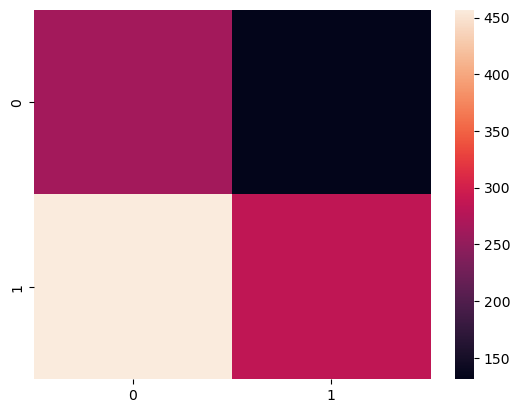

[[263 131]
 [457 285]]
roc_auc: 0.5258048626978805 Accuracy: 0.4823943661971831 f1: 0.49222797927461137 recall: 0.38409703504043125 precision: 0.6850961538461539


In [63]:
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)